## Pattern recognition (Corruption, Recovery, Simulation and Analysis) using the Hopfield Model
to be given a proper title 

### Authors:
- **Ballarin Marco**,   $\textit{Master's in Physics of Data student unipd}$
- **Iriarte Delfina**,  $\textit{Master's in Physics of Data student unipd}$
- **Segalini Beatrice**, $\textit{Master's in Physics of Data student unipd}$
- **Magenya Joemah**,   $\textit{Master's in Physics of Data student unipd}$

### Supervised by:
- Professor Baiesi Marco, unipd

# **Hopfield model project**

Artificial Neural Networks (ANN) are computational techniques that aim to realize a very simplified model of the human brain. In this way, ANN try to learn tasks mimicking the behavior of brain, which is composed of a large set of elements, specialized cells called neurons. Each single neuron is a very simple entity but the power of the brain is given by the fact that neurons are numerous and strongly interconnected between them. The human brain is one of the most computationally efficient device that is why in the late years a lot of effort has been done in order to develop an artificial version of it, as a matter of fact companies like Telsa motors are developing self driving cars which are based on ANN to implement the behavior of the human brain in computer systems. 

The easiest way to represent a neuron is either "on or off" with the synapsys either eccitative or inibitive. We can easily map the neural network into a spin system by mapping neurons in spins $\{s_i\}_{i=1,\cdots,N}$ and synapsys into the magnetic coupling $J_{ij}$.
By a specific representation of these coupling costant we can define the Hopfield model.

## The Hopfield Model

The Hopfield model is a fully connected neural network able to recall stored memories starting from a noisy or distorted input. The Hopfield network consists of $N$ neurons connected through symmetric bidirectional links. The neuron interactions are encoded in the connection matrix, a $N × N$ real symmetric matrix without self-interaction terms, whose $J_{ij}$ entries define the weight of the connection between neuron $i$ and $j$. 

The model respect the following mapping:

$$
n = \{0,1\} \longrightarrow s = \{-1,1\}    
$$
                                   
where $n$ is the neuron and $s$ the spin. 
The correct transformation of this mapping is:

$$
\begin{equation}
s = f(n) = \frac{2n-1}{2}
\end{equation}
$$

We define the synapses as:
$$
J_{ij}=\begin{cases}
+1 & \mbox{ excitatory synapses} \\
-1 & \mbox{ inhibitory synapses}
\end{cases}
$$

A neuron is activated if it receives a sufficient number of active impulses, and we can compute these impulses as follows:
$$
\begin{equation}
h_i(t) = \sum^N_{j=1,j\neq i} J_{ij}(s_j(t)+1)
\label{eq:h} 
\end{equation}
$$
It is important to notice that $j\neq i$ since the neuron $\textit{does not}$ interacts with itself.
To decide if these impulses are sufficient to activate the neuron, we apply a non-linear function to the impulses:
$$
\begin{equation}
s_i(t+1)=sign{\left(h_i(t)-\theta_i\right)}
\end{equation}
$$
where $\theta_i$ is a fixed threshold. We choose this threshold in a way that is useful for the calculations:
$$
\theta_i = \sum^N_{j=1,j\neq i} J_{ij}.
$$
By applying this threshold, we obtain the following $\textbf{update rule}$, which we will be using below in the code:
$$
\\
\begin{equation}
s_i(t+1)=sign{\left(\sum^N_{j=1,j\neq i} J_{ij}s_j(t)\right)}
\label{eq:upd}
\end{equation}
\\
$$
The $\textbf{Hopfield model}$ that we will exploit in our work consists of a specific choice for the synapses ($\textit{magnetic couplings}$):
$$
\\
\begin{equation}
\begin{cases}
J_{ii}=0 & \mbox{ known as Hebb rule} \\
J_{ij}=\frac{1}{N}\sum_{\mu=1}^{p} \xi^\mu_i\xi^\mu_j
\end{cases}
\label{eq:hop}
\end{equation}
\\
$$
where the $\vec{\xi^\mu}$ are $p<<N$ excitatory pattern with $\xi^\mu_i=\{+1,-1\}$.
This choice encodes these patterns in the couplings and gives to the system some interesting properties:
- If the system starts from a configuration equal to a pattern $\vec{\xi^\mu}$ and we apply the update rule of Eq $\eqref{eq:upd}$, it remains in that pattern $\forall t$.
- By solving the system from a statistical mechanics point of view, it turns out that all the minima of the system corresponds to the patterns.

It is instructive to see the proof of the stability of the patterns.
$$
s(1)=sign{\left(\sum^N_{j=1} J_{ij}s_j(0)\right)}\overset{s_j(0)=\xi^\mu_j}{=}
sign{\left(\sum^N_{j=1} \frac{1}{N}\sum^p_{\nu=1}\xi_i^\nu\xi_j^\nu\xi_j^\mu\right)} 
\\=sign{\left(\sum^N_{\nu=1}\xi_i^\nu\frac{1}{N}\sum^p_{j=1}\xi_j^\nu\xi_j^\mu \right)} 
=sign{\left(\sum^N_{\nu=1}\xi_i^\nu(\delta_{\mu\nu}+O(N^{-\frac{1}{2}}) \right)}
\simeq sign\left(\xi^\mu_i \right)=\xi^\mu_i
$$
And so the property enuciated before holds.

From now on we will talk about spins and not neurons anymore.

This model take into account fully connected systems, where each spin is connected to all the others. But what happen if we consider an interaction lenght $R$? It is an interesting question to look at how the results vary with this assumption.

Moreover, this type of system does not need training, differently to other neural networks, and so it can be really interesting if the results are good.

In conclusion, the aim of this work is to start from this theoretical model and further analyze it, by studying the stability of the patterns, the recovering of corrupted ones and simulate its dynamics with a Montecarlo method.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as scp
from copy import deepcopy
import time as time
from scipy.optimize import curve_fit

## Stability of the model

In this first section, we are going to discuss about the stability of the Hopfield model, especially focusing on these main points:

- 
- 

In [3]:
# Parameters
L = 10   # Length of the edge of the image
N = L**2 # Number of spins 
p = 10   # Number of patterns
MF = 0   # Use or not the Mean Field strategy: if MF = 1 uses MF, if MF = 0 only spins at
         # a distance R interacts
R = 3    # The 3-nearest neighbor interacts
np.random.seed(1234) # Seed to make the random process reproducible

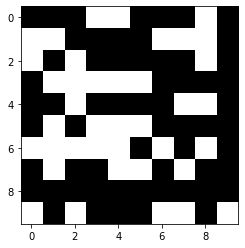

In [4]:
# Patterns
def random_patterns(N,p):
    xi = np.random.randint(0,2,N*p).reshape(p,N) # Each line is a pattern
    xi[xi==0]=-1
    return xi

xi = random_patterns(N,p)
idx = np.random.randint(0,p)
plt.imshow(xi[idx].reshape(L,L),cmap='Greys') # This is an example of pattern 
# -1 = white, +1 = black

In [5]:
# Coupling constant
# Row i is the connections of the i-th neuron with the others.
# Note that the Hopfield model requires Jii=0
# Note that J is a symmetrical matrix (J=J.T)

def MF_coupling(xi,N):
    J = 1/N * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(N) for j in range(N) ] )
    J = J.reshape(N,N)        
    for i in range(len(J)):
        J[i,i] = 0
    return J

def R_coupling(xi,N,R):
    J = MF_coupling(xi,N)
    for i in range( J.shape[0] ):
        J_temp = J[i].reshape(L,L)
        for j in range(L):
            y = (i%L -j)**2 
            for k in range(L):
                if np.sqrt( (i//L - k)**2 + y ) > R: J_temp[j,k] = 0
        J[i] = J_temp.reshape(1,N)
    return J

if MF: J = MF_coupling(xi,N)
else: J = R_coupling(xi,N,R)

In [6]:
# Update rule

def update(sys): #sys is the initial image
    N = len(sys) 
    for i in range(N):
        temp = 0
        for j in range(N): 
            temp +=  J[i][j]*sys[j] 
        if temp == 0: temp = 2*np.random.randint(0,2)-1 #in order not to have grey pixels
        sys[i] = np.sign(temp)
    return np.sign(sys)

def deterministic_hopfield(sys, t): #t is the number of iterations
    for i in range(t):
        sys = update(sys)
    return sys

#we define the error as the number of different pixels between a pattern and the image 
#normalized to the system size
def error_im(xi_idx, sys): #xi_idx is the "correct" pattern
    wrong_pixels = (np.abs( sys-xi_idx )/2).sum()
    return wrong_pixels/len(sys)

def assign_pattern(xi,sys): #xi are the patterns
    errors = [ error_im(i,sys) for i in xi ]
    correct = np.argmin(errors)
    return correct 

#calculate score and error for all the possible patterns
def total_error(xi,t):
    errors = []
    prediction = []
    for mu in range(len(xi)):
        sys = deterministic_hopfield(xi[mu],t)
        errors.append( error_im(xi[mu],sys) )
        if assign_pattern(xi,sys)==mu:
            prediction.append( 1 )
        else: prediction.append( 0 )
    errors = (np.array(errors)).mean()
    prediction = np.array(prediction).sum()/len(xi)
    return errors, prediction

The error of the algorithm is 0.190000
The algorithm recognised the pattern 2 and the correct pattern is 2


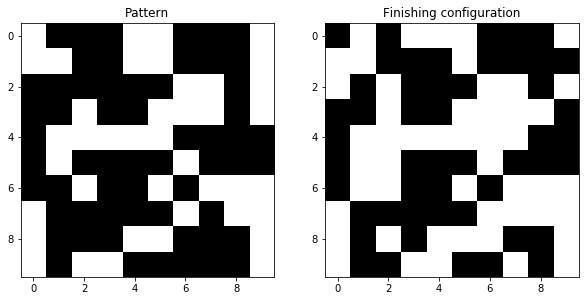

In [7]:
# actual algorithm

idx = np.random.randint(0,p) #randomly chosen pattern
sys = deepcopy(xi[idx])

sys = deterministic_hopfield(sys,100)
wrong_pixels = error_im(xi[idx],sys)
assigned_pattern = assign_pattern(xi,sys)

fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].set_title('Pattern')
ax[0].imshow(xi[idx].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

## Analysis

At first we studied how the performances of the algorithm depended on the number of patterns $p$. The system size was fixed to $L=16$ for the first case, then we changed it to other sizes in order to compare the error and score. Both the Mean Field model (MF) and the Non Mean Field one (NMF) have been studied.

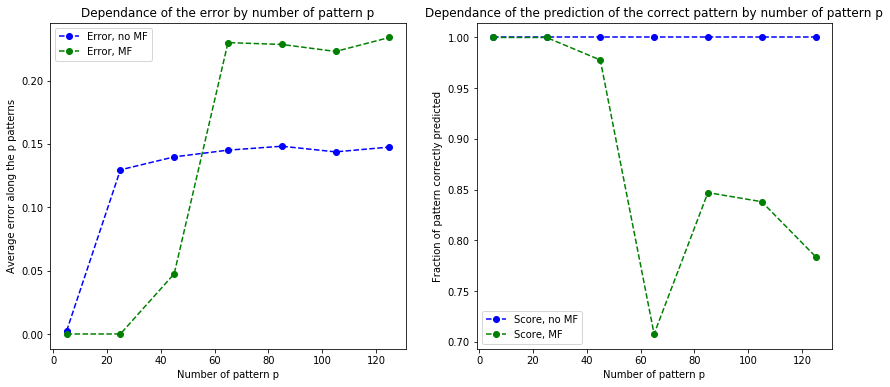

In [8]:
L = 16
N = L**2

P = np.arange(5,N/2,20)
scores_16 = [[],[]]
errors_16 = [[],[]]

for MF in range(2):
    for p in P: 
        p = int(p)
        xi = random_patterns(N,p)
        if MF: J = MF_coupling(xi,N)
        else: J = R_coupling(xi,N,R)
        err, pred = total_error(xi,30)    
        scores_16[MF].append( pred )
        errors_16[MF].append(err)

figp, axp = plt.subplots(1,2, figsize=(14,6))
axp[0].set_title('Dependance of the error by number of pattern p')
axp[0].set_xlabel('Number of pattern p')
axp[0].set_ylabel('Average error along the p patterns')
axp[0].plot(P,errors_16[0],  '--bo', label='Error, no MF')
axp[0].plot(P,errors_16[1], '--go', label='Error, MF')
axp[0].legend()

axp[1].set_title('Dependance of the prediction of the correct pattern by number of pattern p')
axp[1].set_xlabel('Number of pattern p')
axp[1].set_ylabel('Fraction of pattern correctly predicted')
axp[1].plot(P,scores_16[0], '--bo', label='Score, no MF')
axp[1].plot(P,scores_16[1], '--go', label='Score, MF')
axp[1].legend()

<img src=".\Images\stability_p_error_and_scores.png">

The dependance of error with patterns generally follows an increasing tendency at the beginning of the curve, which then flatters, reaching a plateau. The growth is particularly steep in the case of the NMF model, which reaches its maximum within the first $40$ patterns. It is instead less pronounced for the MF theory: here the highest value ($\approx 0.25$) is reached only after about $70$ patterns. The plateau of the NMF graph is, on the contrary, more stable, showing almost no oscillation around the value of $0.15$, which is also lower than the MF one.

Concerning the dependence of the prediction of the correct pattern with number of patterns, it can be observed that, in case of NMF model, the score is always constant whichever the pattern, thus the independence of the error with number of patterns and the perfect effectiveness of the predictions. However, with the MF model, this stability is not preserved: in fact, after passing the first few patterns, the score drops to about $70\%$, and oscillates around that value.

These results can be justified by the structure of the models themselves: indeed, the Mean Field one is more influenced by similar patterns, since it averages over all the spins, while the Non Mean Field is more "details oriented" and will perceive small differences without looking at the whole image. 

It can be stated, after these considerations, that the Non Mean Field algorithm is more effective in studying the dependance of the error and score as functions of the number of patterns. As a consequence, for further analysis this model will be used.

By observing both graphs, it can be observed that there exist an optimal value of $p$ patterns which optimize the performances of the algorithm, which in this case is around $20$ (about $8\%$ of the system size, which is $\approx \sqrt{N} = L$ ). In order to verify if this tendency is preserved, different system sizes are studied.

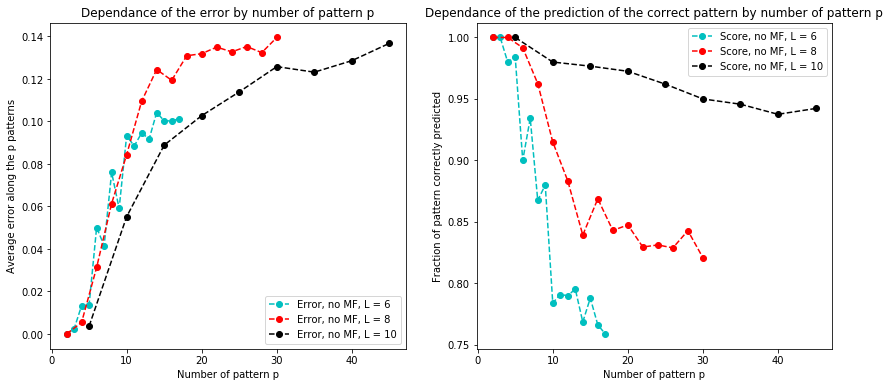

In [9]:
L = 10
N = L**2
P_10 = np.arange(5,N/2,5)
scores_10 = []
errors_10 = []
sigma_10 = []

MF = 0

for pi in P_10: 
    err = []
    pred = []
    for n in range(20):
        p = int(pi)
        xi = random_patterns(N,p)
        if MF: J = MF_coupling(xi,N)
        else: J = R_coupling(xi,N,R)
        e, p = total_error(xi,30)    
        err.append(e)
        pred.append(p)
    pred = np.array(pred)
    err = np.array(err)
    sigma_10.append( pred.std() )
    scores_10.append( pred.mean() )
    errors_10.append( err.mean() )
    
L = 6
N = L**2
P_6 = np.arange(2,N/2,1)
scores_6 = []
errors_6 = []
sigma_6 = []

for pi in P_6: 
    err = []
    pred = []
    for n in range(50):
        p = int(pi)
        xi = random_patterns(N,p)
        if MF: J = MF_coupling(xi,N)
        else: J = R_coupling(xi,N,R)
        e, p = total_error(xi,30)    
        err.append(e)
        pred.append(p)
    pred = np.array(pred)
    err = np.array(err)
    sigma_6.append( pred.std() )
    scores_6.append( pred.mean() )
    errors_6.append( err.mean() )

L = 8
N = L**2
P_8 = np.arange(2,N/2,2)
scores_8 = []
errors_8 = []
sigma_8 = []

for pi in P_8: 
    err = []
    pred = []
    for n in range(40):
        p = int(pi)
        xi = random_patterns(N,p)
        if MF: J = MF_coupling(xi,N)
        else: J = R_coupling(xi,N,R)
        e, p = total_error(xi,30)    
        err.append(e)
        pred.append(p)
    pred = np.array(pred)
    err = np.array(err)
    sigma_8.append( pred.std() )
    scores_8.append( pred.mean() )
    errors_8.append( err.mean() )

figp, axp = plt.subplots(1,2, figsize=(14,6))
axp[0].set_title('Dependance of the error by number of pattern p')
axp[0].set_xlabel('Number of pattern p')
axp[0].set_ylabel('Average error along the p patterns')
axp[0].plot(P_6,errors_6, '--co', label='Error, no MF, L = 6')
axp[0].plot(P_8,errors_8, '--ro', label='Error, no MF, L = 8')
axp[0].plot(P_10,errors_10, '--ko', label='Error, no MF, L = 10')
axp[0].legend() 

axp[1].set_title('Dependance of the prediction of the correct pattern by number of pattern p')
axp[1].set_xlabel('Number of pattern p')
axp[1].set_ylabel('Fraction of pattern correctly predicted')
axp[1].plot(P_6, scores_6, '--co', label='Score, no MF, L = 6')
axp[1].plot(P_8, scores_8, '--ro', label='Score, no MF, L = 8')
axp[1].plot(P_10, scores_10, '--ko', label='Score, no MF, L = 10')
axp[1].legend()

<img src=".\Images\err_score_p_diffsizes.png">

From the comparison of system with different sizes, one can deduce that the hypothesized tendency is respected. In fact, the scores show the steepest descent with a number of $p$ close to the $\sqrt{N}$; in the other graph, at the same abscissa, the error raise is the biggest. 

## How does the time scales with the number of spins N?

In this section, the focus of the analysis is moved to implementation time. It is important to state that the actual values derived are not significant, as they strongly depend on the hardware used. We studied different $L$s for both Mean Field and Non Mean Field models, even if we expect the same trend.

In [10]:
L = np.arange(10,28,4)
N = L**2 
p = 10
times = [[],[]]

for MF in range(2):
    for n in N:
        xi = np.random.randint(0,2,n*p).reshape(p,n)
        xi[xi==0]=-1
        J = 1/n * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(n) for j in range(n) ] )
        J = J.reshape(n,n)
        for k in range(len(J)):
            J[k,k] = 0
        idx = np.random.randint(0,p)
        start = time.time()
        deterministic_hopfield(xi[idx],30)
        end = time.time()
        times[MF].append(end-start)


<img src=".\Images\time.png">

The two curves above show both an exponential growth of the implementation time as a function of the size of the system. The tendency does not change for both Mean Field and Non Mean Field models: this is consistent with the fact that the two algorithms are implemented with the same logic, just by changing the coupling rule.


## How does the time scales with the number of pattern p with a fixed N?

Now we analyse the behaviour of implementation time with respect to the number of pattern p with a fixed system size, for both Mean Field and Non Mean Field models.

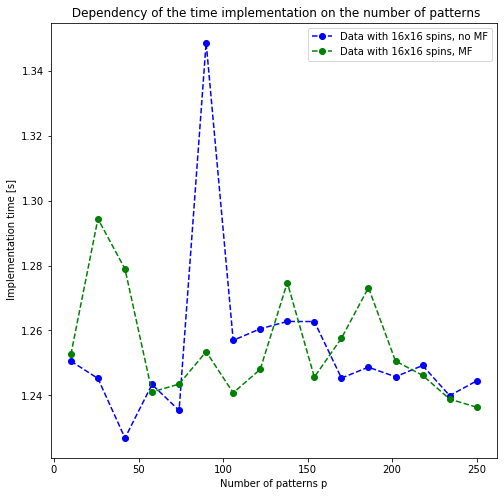

In [11]:
L = 16
N = L**2 
P = np.arange(10,N,16)
times = [[],[]]

for MF in range(2):
    for p in P:
        p = int(p)
        xi = np.random.randint(0,2,N*p).reshape(p,N)
        xi[xi==0]=-1
        J = 1/N * np.array( [ (xi[:,i]*xi[:,j]).sum() for i in range(N) for j in range(N) ] )
        J = J.reshape(N,N)
        for k in range(len(J)):
            J[k,k] = 0
        idx = np.random.randint(0,p)
        start = time.time()
        deterministic_hopfield(xi[idx],30)
        end = time.time()
        times[MF].append(end-start)

fig, ax = plt.subplots(figsize = (8, 8))
ax.plot(P,times[0], '--bo', label = 'Data with 16x16 spins, no MF')
ax.plot(P,times[1], '--go', label = 'Data with 16x16 spins, MF')
ax.set(xlabel = 'Number of patterns p', ylabel =' Implementation time [s]', 
              title = ' Dependency of the time implementation on the number of patterns')
ax.legend()

<img src=".\Images\stability_pattern_time.png">

In this graph the implementation time as a function of the number of patterns is displayed. The shape of the curve does not outline any particular tendency, and oscillates randomly showing instability.
The Mean Field model has less pronounced fluctuations with respect to the Non Mean Field one.


## Changing the number of neighbors

We have seen that the Non Mean Field model seems to be more stable and lead to smaller errors. It is then relevant to study how the model evolves if we change the number $R$ of neighbors. 

<ErrorbarContainer object of 3 artists>

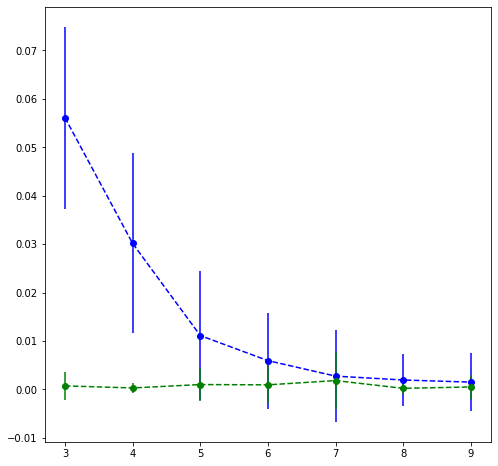

In [12]:
MF = 0
L = 10
N = L**2 
P = 10
error_R = [[],[]]
sigmas_R = [[],[]]
R = np.arange(3,L)

for MF in range(2):
    for r in R: 
        supp = []
        for n in range(50):
            xi = random_patterns(N,P)
            if MF: J = MF_coupling(xi,N)
            else: J = R_coupling(xi,N,r)
            err, pred = total_error(xi,30)    
            supp.append(err)
        supp = np.array(supp)
        error_R[MF].append(supp.mean())
        sigmas_R[MF].append(supp.std())
        
fig, ax = plt.subplots(figsize = (8,8))
ax.plot(R,error_R[0], '--bo', label = 'no MF')
ax.errorbar(R,error_R[0], yerr=sigmas_R[0], fmt='none', color='b')
ax.plot(R,error_R[1], '--go', label = 'MF')
ax.errorbar(R,error_R[1], yerr=sigmas_R[1], fmt='none', color='g')


<img src=".\Images\R_p.png">

A decreasing tendency in the value of the error can be outlined in the graph above. 
The errorbars are added after calculating the standard deviation of the error along several iterations, and are significant for the NMF model. Concerning the MF one, we can observe very small errors due to the fact that all the value are indeed close to zero: this happens because we are considering a deterministic evolution and because the MF model does not depend on the number of neighbors, as it is considering an average of all the interactions along the grid.

Nevertheless, the most striking feature is that the NMF model approaches the MF one with the increasing number of neighbors. This is just as it can be predicted: as a matter of fact, increasing $R$ means increasing the radius of interactions between spins. By including more and more and more spins, the coupling function will become closer to the average field along all the grid. Hence, the two models will become more similar with bigger $R$s.


## Distinguish criteria of similar pattern

The aim of this section is to define in a more rigorous way when two patterns are considered $\textit{similar}$ and when they are easily distinguishable by the MF and NMF models.

In order to do so, we define a new error function which weights the different pixels between two patterns with respect to their distance: so we will consider bigger the error if wrong pixels are close to each other. 


In [13]:
def w_error(sys11, sys22, alpha):
    sys1 = deepcopy(sys11)
    sys2 = deepcopy(sys22)
    N = sys1.shape[0]
    L = int(np.sqrt(N))
    sys1 = sys1.reshape(L,L)
    sys2 = sys2.reshape(L,L)
    wrong1 = []
    wrong2 = []
    min_dist = []
    for i in range(L):
        for j in range(L):
            if sys1[i][j] == sys2[i][j]: continue
            elif sys1[i][j]== 1 : 
                wrong1.append( np.array([i,j]) )
            elif sys2[i][j]== 1:
                wrong2.append( np.array([i,j]) )
    for i in wrong1:
        distances = []
        for j in wrong2:
            if np.linalg.norm(i-j) !=0 :
                distances.append( np.linalg.norm(i-j) )
        min_dist.append( np.array(distances).min() )
    min_dist = np.array(min_dist)
    err =  (1/(min_dist)**alpha).sum()
    return err
                

DOOOOO STUFFFFFF

# Corruption of patterns

## Why noise in pattern recognition

Noise is the amount of meaningless information contained in corrupted data. It incorporates any type of data that a user system cannot understand or interpret correctly.
Using improper procedures to getting rid of noise in the data can lead to inaccurate results and false conlusions. Noise reduction is very important in order to obtain accurate results. 

We implemented different types of noises to discuss how the patterns differs when they are applied. In this work, we used the following noises:
- uniform noise 
- gaussian noise
- cauchy noise


In [14]:
#function for plotting
def plot(x, y, sys):
    fig, ax = plt.subplots(1,3, figsize=(15,8))
    ax[0].set_title('Original pattern')
    ax[0].imshow(x.reshape(L,L),cmap='Greys')
    ax[1].set_title('Corrupted pattern')
    ax[1].imshow(y.reshape(L,L),cmap='Greys')
    ax[2].set_title('Recovered pattern')
    ax[2].imshow(sys.reshape(L,L),cmap='Greys')
    plt.show()

#function to run the algorithm
def algorithm(xi, idx, yi):  #yi is the corrupted pattern
    sys = deterministic_hopfield(yi,30)
    wrong_pixels = error_im(xi[idx],sys)
    assigned_pattern = assign_pattern(xi,sys)
    return wrong_pixels, assigned_pattern, sys


## Uniform noise

A uniform noise is consider as equally distributed along the pixels. To interpret the data, we define $q$ as a threshold probability. In order to corrupt the original pattern, a random number $r$ is generated with $\textit{uniform distribution}$ for each pixel. If $r$ is less than the threshold, then that pixel is flipped. After corrupting the original pattern, the deterministic Hopfield function is called in order to produce a $\textit{Recovered}$ one. 

The error with respect to the original pattern is then calculated. 


The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


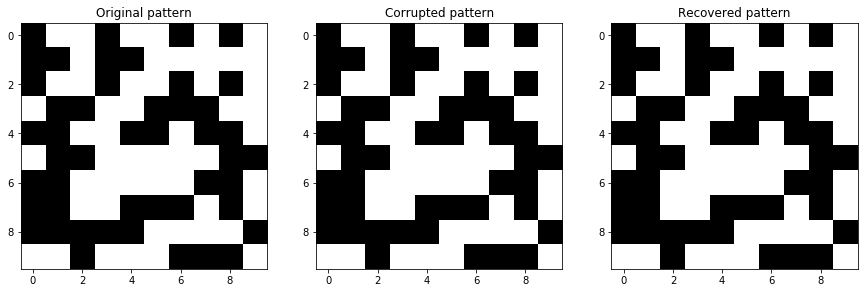

In [15]:
#Creates corrupted random data.
def corrupt_uniform(sys, q): #q is the threshold probability
    sys_temp = deepcopy(sys)
    N = sys.shape[0]
    for i in range(N):
        r = np.random.rand()
        if r < q:
            sys_temp[i] *= -1
    return sys_temp
    
#Testing the function
idx = 1
yi = corrupt_uniform(xi[idx],0.1)
wrong_pixels, assigned_pattern, sys =algorithm(xi, idx, yi)
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))
plot(xi[idx], yi, sys)

# Varying the probability

In this section we change the values of the probabilities in order to visualize how the system behaves using both MF and NMF.

In [1]:
#Set the probabilities between 0 and 1
probabilities = np.arange(0,1,0.05)
error = [[],[]]
sigma = [[],[]]

MF = [0,1]
for i in MF:
    for q in probabilities:
        supp = []
        for n in range(100):
            yi = corrupt_uniform(xi[idx],q)
            wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
            supp.append(wrong_pixels)
        supp = np.array(supp)
        error[i].append(supp.mean())
        sigma[i].append(supp.std())


NameError: name 'np' is not defined

<ErrorbarContainer object of 3 artists>

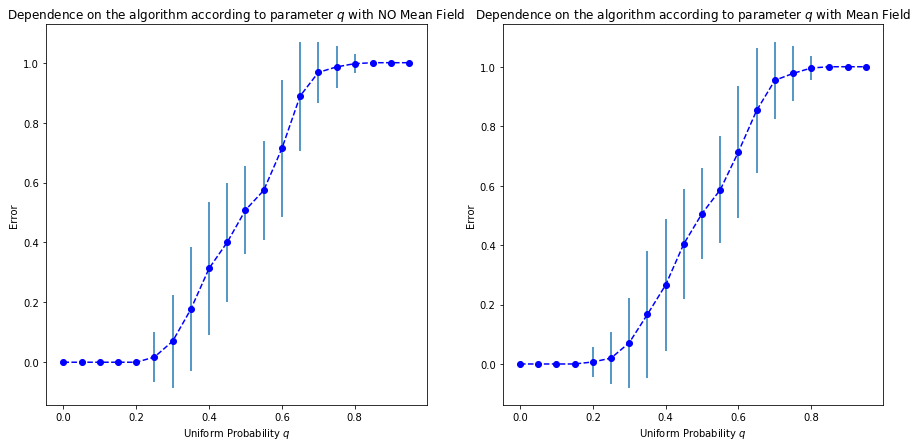

In [17]:
#Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

ax1.plot(probabilities, error[0], '--bo')
ax1.set_title('Dependence on the algorithm according to parameter $q$ with NO Mean Field')
ax1.set_xlabel('Uniform Probability $q$')
ax1.set_ylabel('Error')
ax1.errorbar(probabilities, error[0], yerr = sigma[0], fmt = "none")

ax2.plot(probabilities, error[1], '--bo')
ax2.set_title('Dependence on the algorithm according to parameter $q$ with Mean Field')
ax2.set_xlabel('Uniform Probability $q$')
ax2.set_ylabel('Error')
ax2.errorbar(probabilities, error[1], yerr = sigma[1], fmt = "none")


From the graphs, we can deduced that with the probabilty of about 20% the error remains constant in both cases. This implies that for this given probability the algorithm recover the pattern perfectly. As we expect, the error increase when more pixel are flipped. Moreover, there are not observable differences between the MF and the NMF.

In [23]:
#curve fitting with sigmoid
def sigmoid(x, a, b):
    y = 1 / (1 + np.exp(-b*(x-a)))
    return y

In [24]:
popt, pcov = curve_fit(sigmoid, probabilities, error[0])
print(popt)

popt_MF, pcov_MF = curve_fit(sigmoid, probabilities, error[1])
print(popt)


#plot the results
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 7))

x = np.linspace(0, 1, 10000)
y = sigmoid(x, *popt)

ax1.plot(probabilities, error[0], 'ro', label = 'Original data')
ax1.plot(x, y, 'orange', label = 'Sigmoid fit')
ax1.set_title('Dependence on the algorithm according to parameter $q$ with NO Mean Field')
ax1.set_xlabel('Probability $q$')
ax1.set_ylabel('Error')
ax1.legend()

y = sigmoid(x, *popt_MF)

ax2.plot(probabilities, error[1], 'ro', label = 'Original data')
ax2.plot(x, y, 'orange', label = 'Sigmoidal fit')
ax2.set_title('Dependence on the algorithm according to parameter $q$ with Mean Field')
ax2.set_xlabel('Probability $q$')
ax2.set_ylabel('Error')
ax2.legend()

NameError: name 'curve_fit' is not defined

<img src = "splot.png">

CHECK THIS: THE POINTS ONLY HAVE INTERACTION=1
With the No Mean Field, the sigmoid function fits the data very  well compared to Mean Field. The scattered points of the error increases as the probability $q$ increasing implying that the error tends to maximum when the probability is high. Moreover, since the sigmoid functions fits well the data in No Mean Field version, the version can be described using the sigmoid function while the Mean Field version, a chi-square test or a suitable polynomial function could be used to  describe the data. In both cases points are scattered in a distributive maner meaning that the error is not concentrated in certain values of $q$ but depends on $q$.  

## Gaussian noise

The gaussian distribution is given by:
$$
\\
g(x) = h \cdot \exp{\left[{-\frac{(x-\mu)^2}{2\sigma}}\right]}
\\
$$
where $h$ is the maximum height of the distribution, $\mu$ is its mean and $\sigma$ its standard deviation.

A 2D gaussian, made by the product of two statistically independent gaussians distribution, is used to overlap the original pattern. An arbitrary value of std is chosen as $L/5$ in order to have a gaussian with a well defined peak. The coordinates of the centroids were chosen so as to pick only the most relevant cases i.e the center of the grid and its four corners. 

Concerning the parameter $h$, we decided not to choose the normalized version of the gaussian as it would have been unsignificant to our purpose, so we made $h$ vary between 0.1 and 1 in order to have different threshold.To obtain the corrupted patterns, a random number $r$ is generated using $\textit{gaussian distribution}$ for each pixel. If $r$ is less than the threshold, set by the value of the gaussian in the considered point, then the pixel is flipped. 

After corrupting the patterns, the deterministic Hopfield function is called in order to produce a $\textit{Recovered}$ one. Furthermore, the error with respect to the original pattern is calculated. 


In [20]:
def gaus(mu, sigma, h, x, y): #mu is a 2d array representing the position of the centroid
                              #h is the maximum height of the gaussian
    h = np.sqrt(h)
    g_x = np.exp(-( (x-mu[1])**2 / ( 2.0 * sigma**2 ) ) )*h#/np.sqrt(2*np.pi*sigma**2)
    g_y = np.exp(-( (y-mu[1])**2 / ( 2.0 * sigma**2 ) ) )*h#/np.sqrt(2*np.pi*sigma**2)
    g = g_y * g_x
    return g



The position of the centroid is  [0 0] 

The height of the distribution is  0.1
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


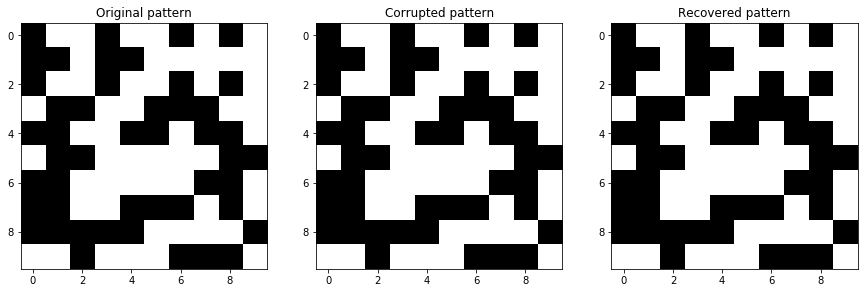

The height of the distribution is  0.2
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


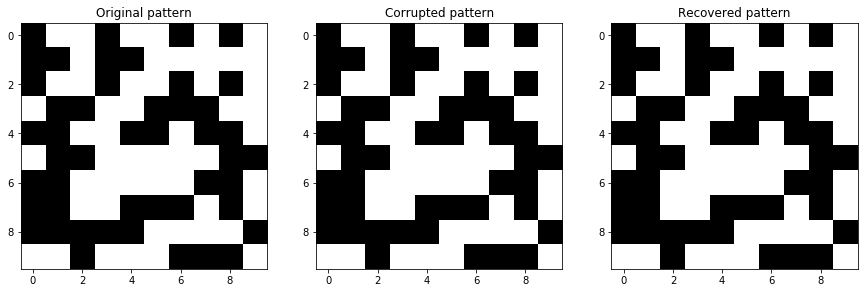

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


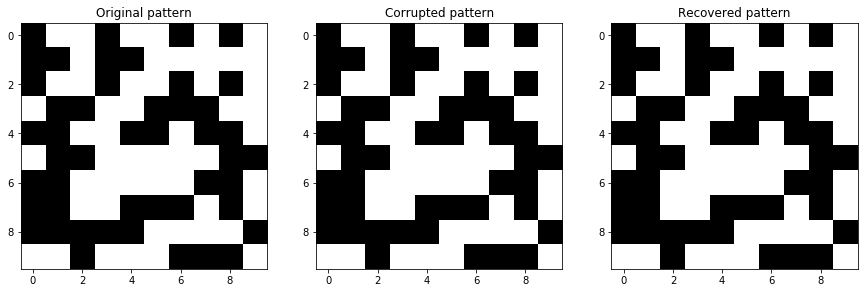

The height of the distribution is  0.4
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


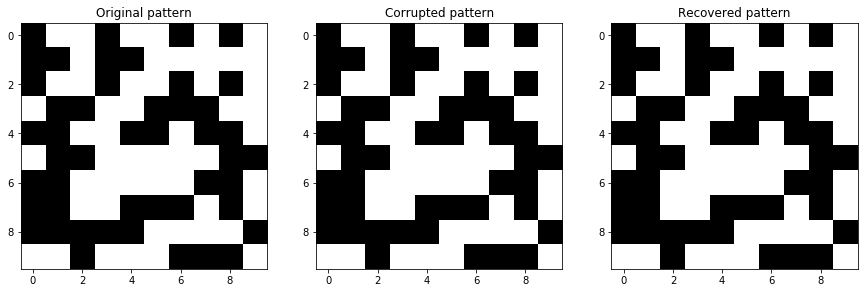

The height of the distribution is  0.5
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


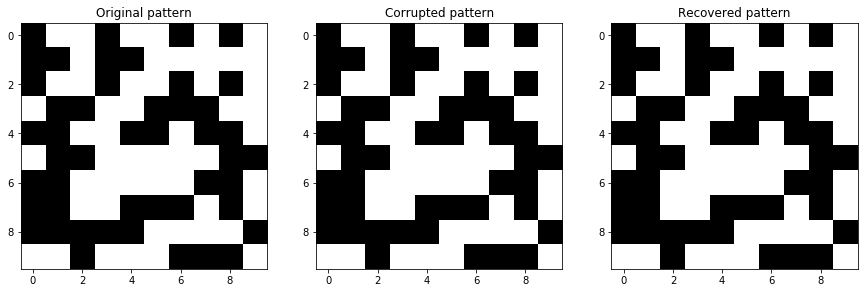

The height of the distribution is  0.6
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


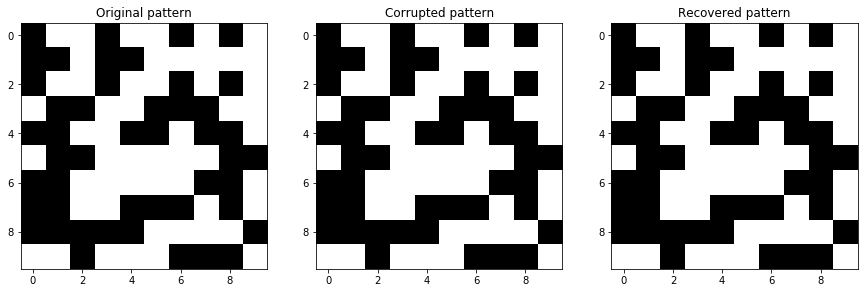

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


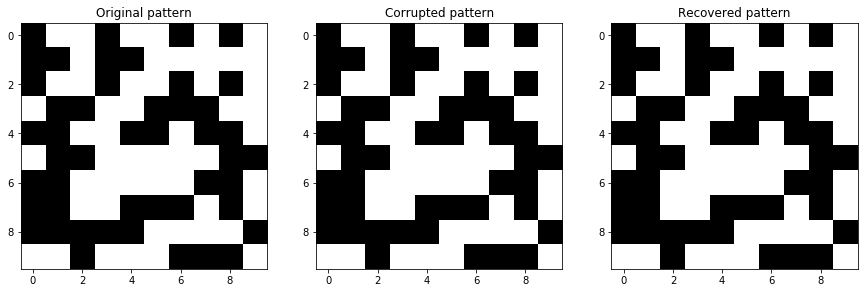

The height of the distribution is  0.8
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


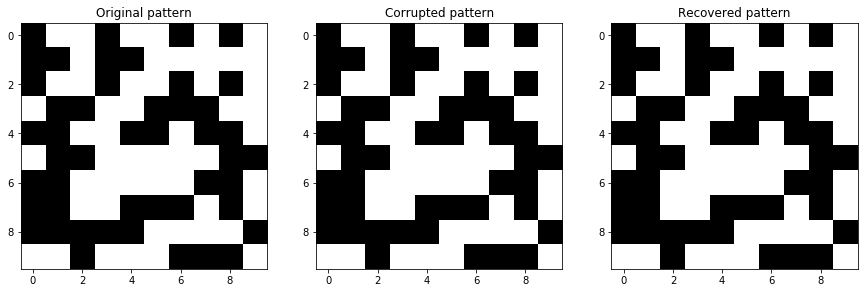

The height of the distribution is  0.9
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


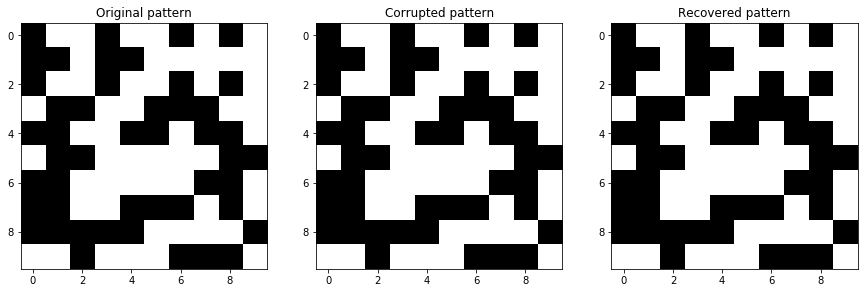

The height of the distribution is  1.0
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


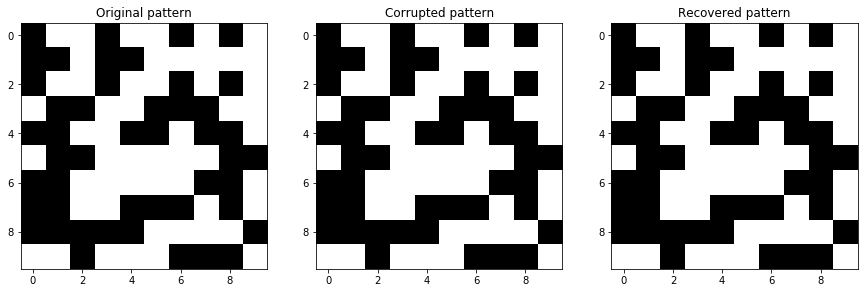

The position of the centroid is  [0 9] 

The height of the distribution is  0.1
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


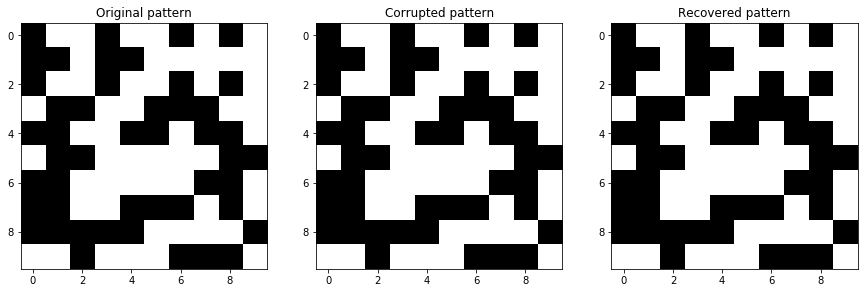

The height of the distribution is  0.2
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


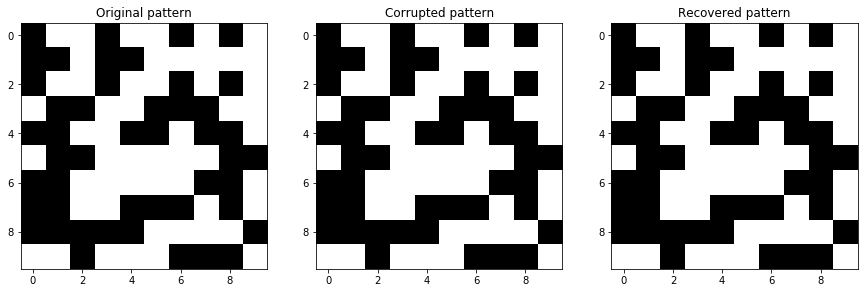

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


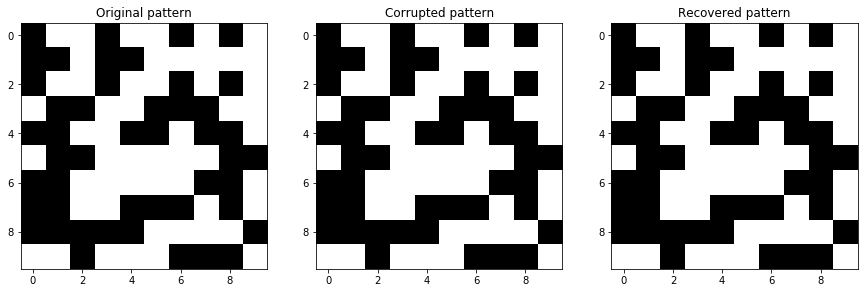

The height of the distribution is  0.4
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


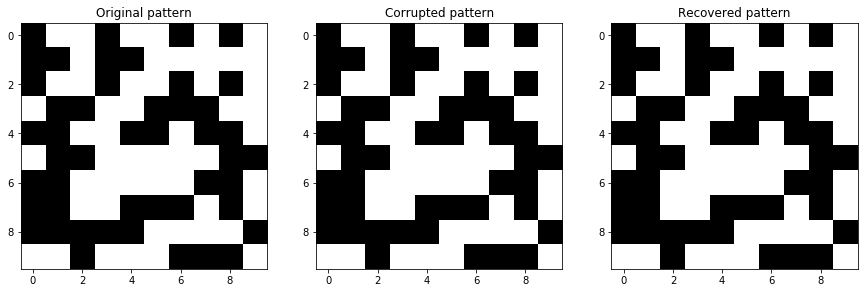

The height of the distribution is  0.5
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


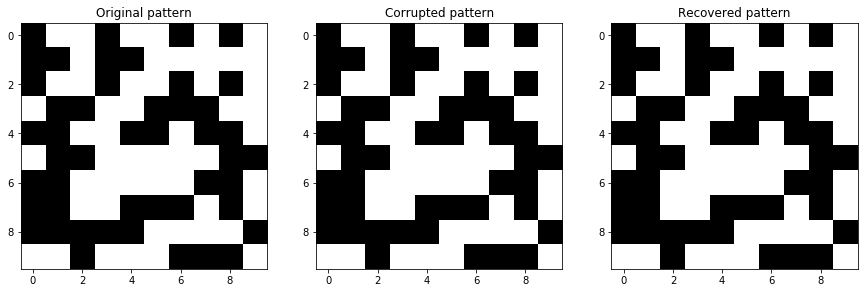

The height of the distribution is  0.6
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


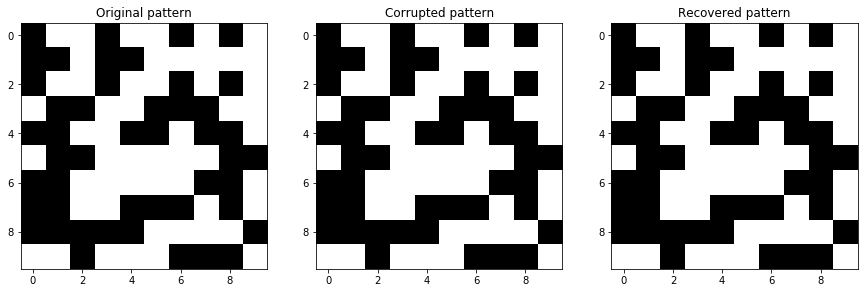

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


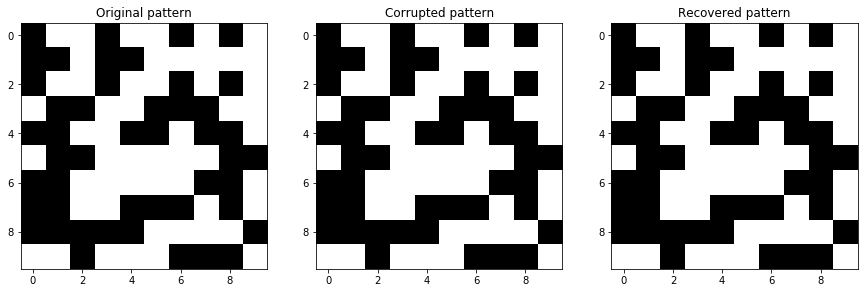

The height of the distribution is  0.8
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


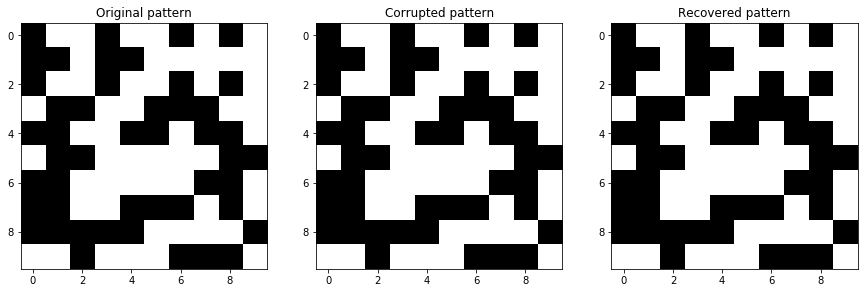

The height of the distribution is  0.9
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


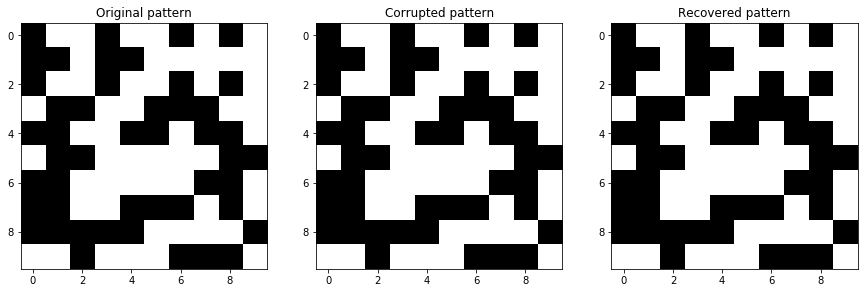

The height of the distribution is  1.0
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


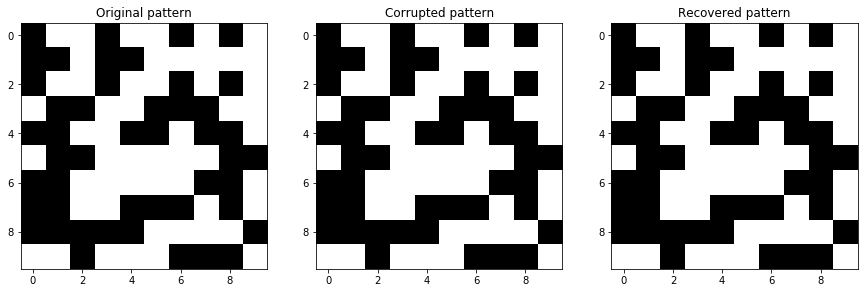

The position of the centroid is  [9 0] 

The height of the distribution is  0.1
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


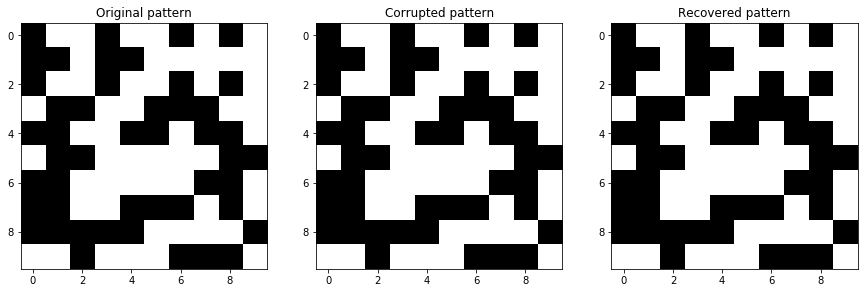

The height of the distribution is  0.2
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


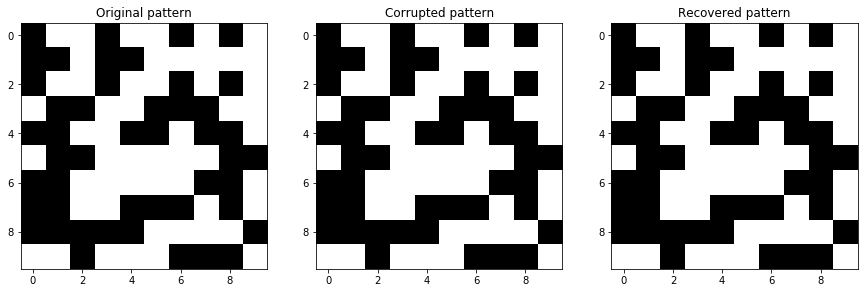

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


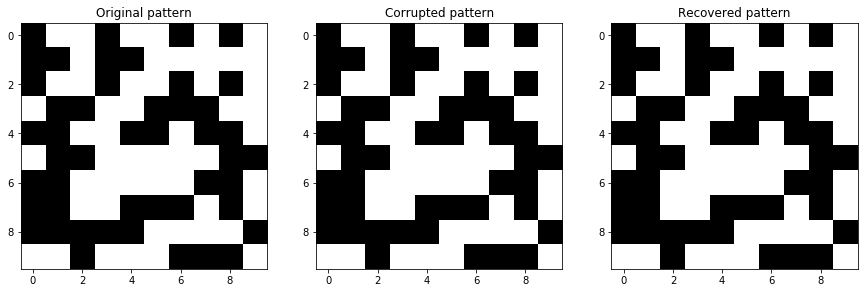

The height of the distribution is  0.4
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


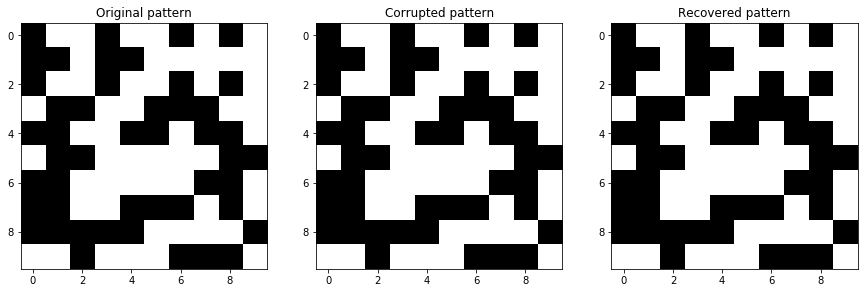

The height of the distribution is  0.5
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


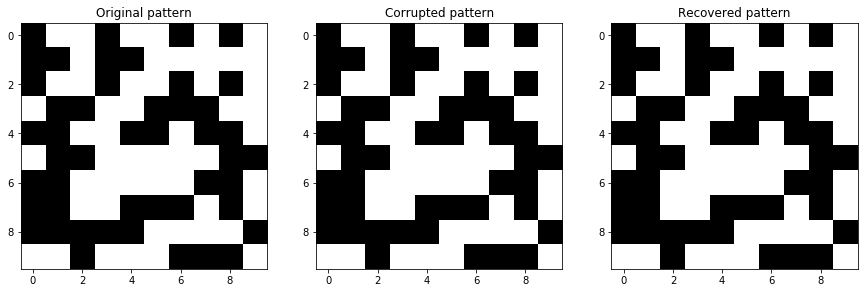

The height of the distribution is  0.6
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


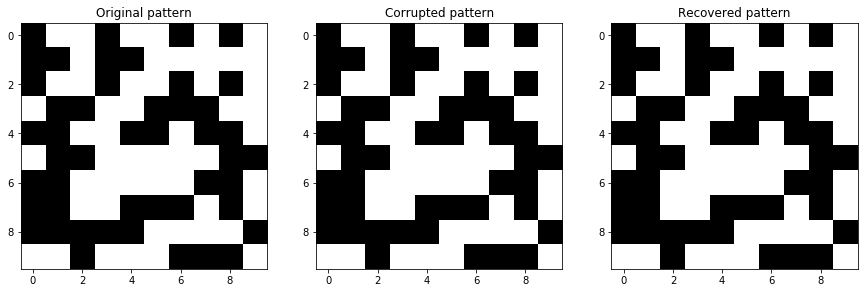

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


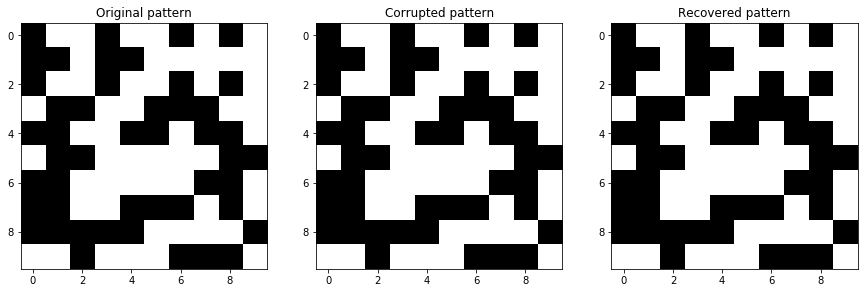

The height of the distribution is  0.8
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


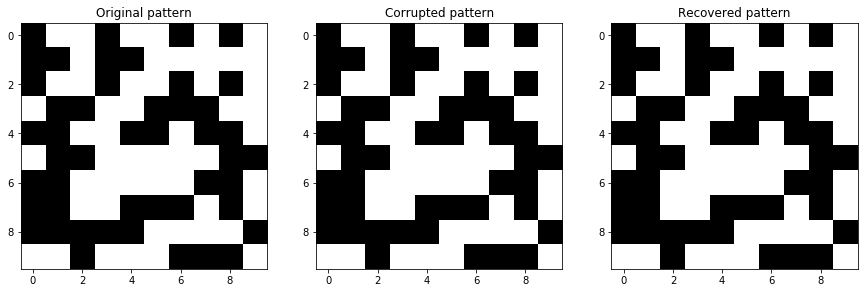

The height of the distribution is  0.9
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


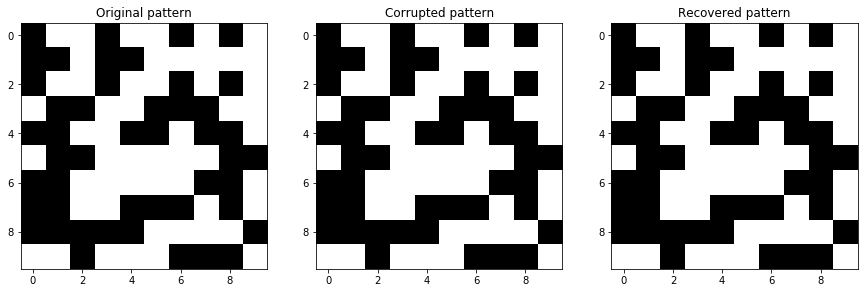

The height of the distribution is  1.0
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


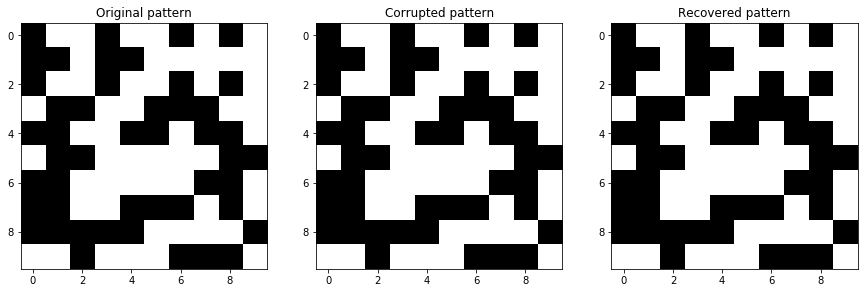

The position of the centroid is  [9 9] 

The height of the distribution is  0.1
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


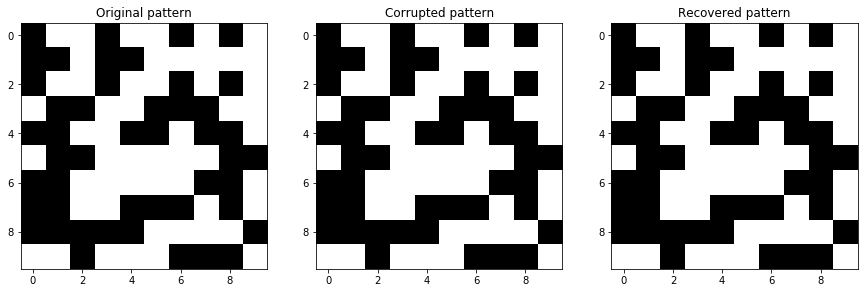

The height of the distribution is  0.2
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


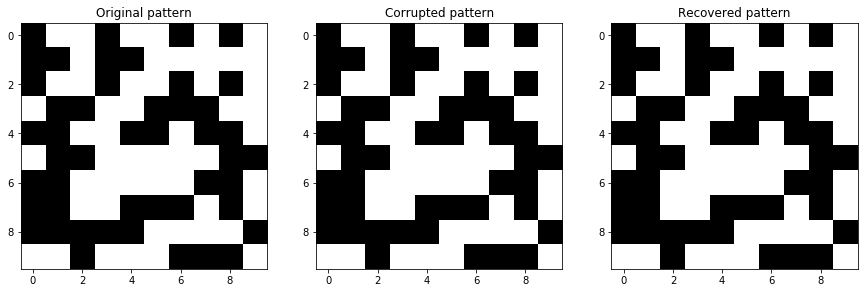

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


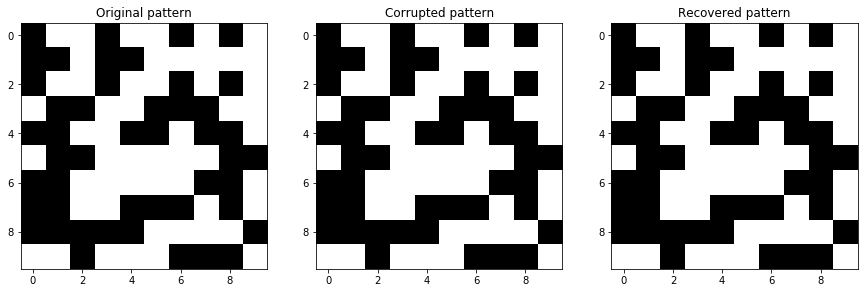

The height of the distribution is  0.4
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


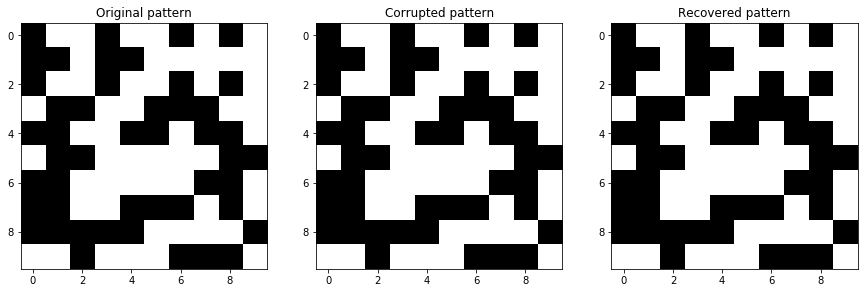

The height of the distribution is  0.5
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


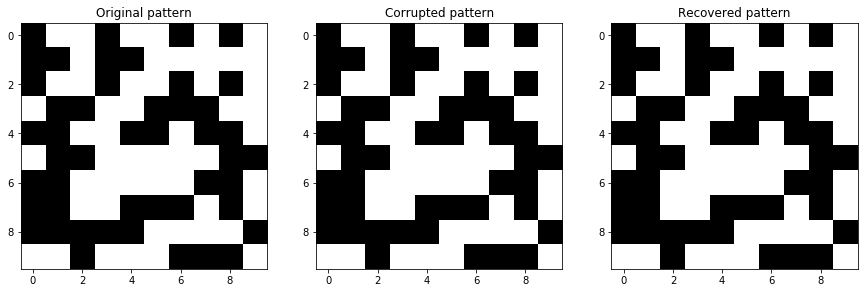

The height of the distribution is  0.6
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


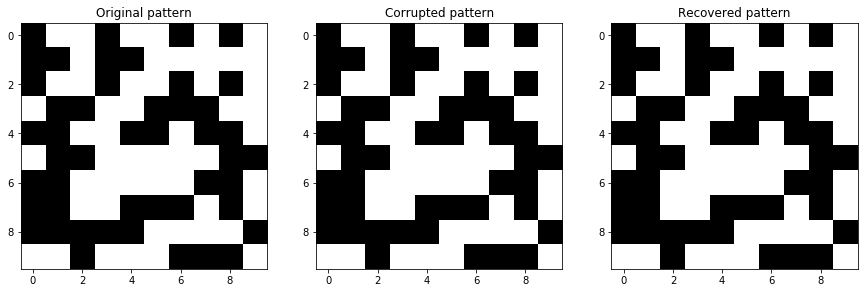

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


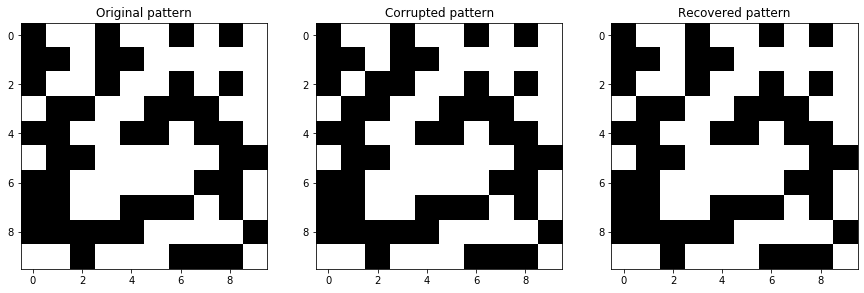

The height of the distribution is  0.8
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


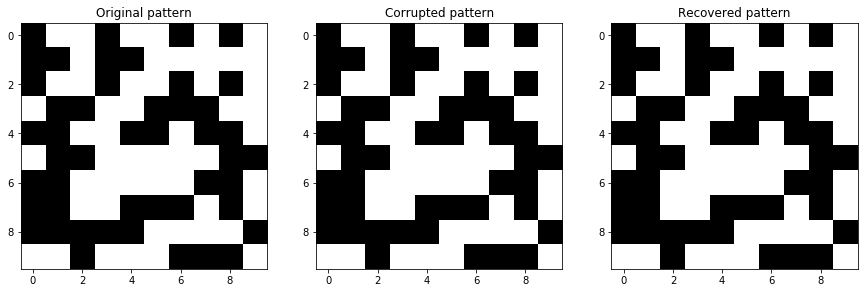

The height of the distribution is  0.9
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


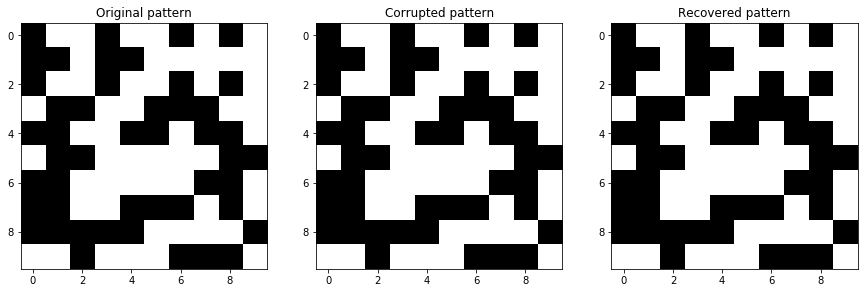

The height of the distribution is  1.0
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


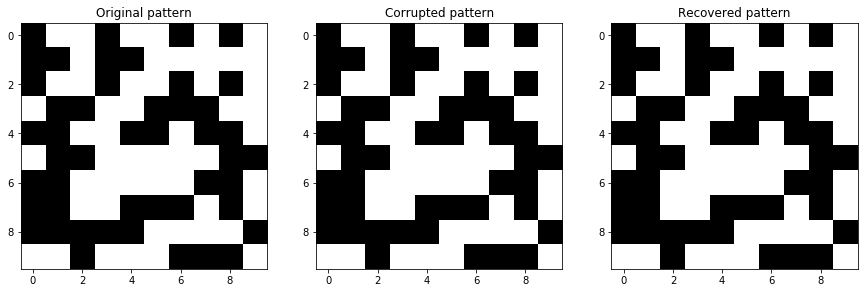

The position of the centroid is  [5 5] 

The height of the distribution is  0.1
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


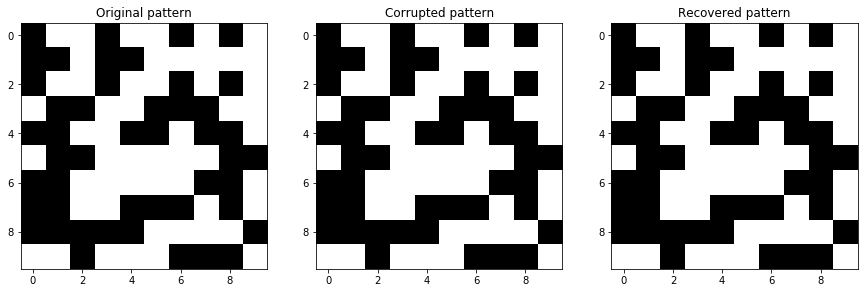

The height of the distribution is  0.2
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


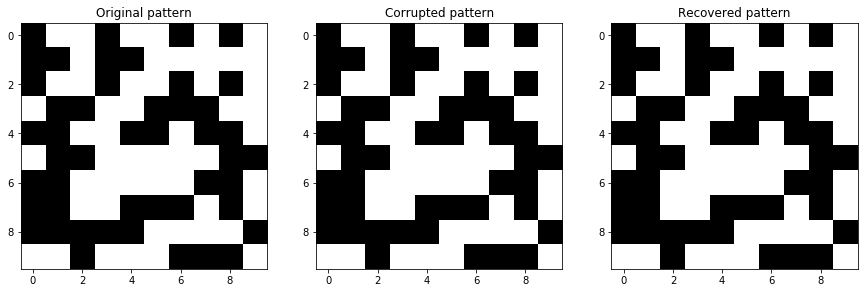

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


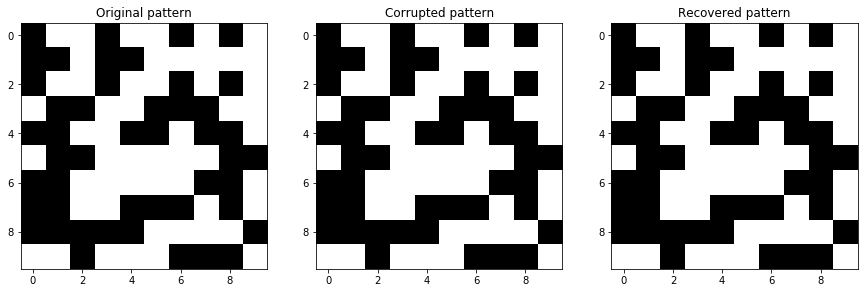

The height of the distribution is  0.4
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


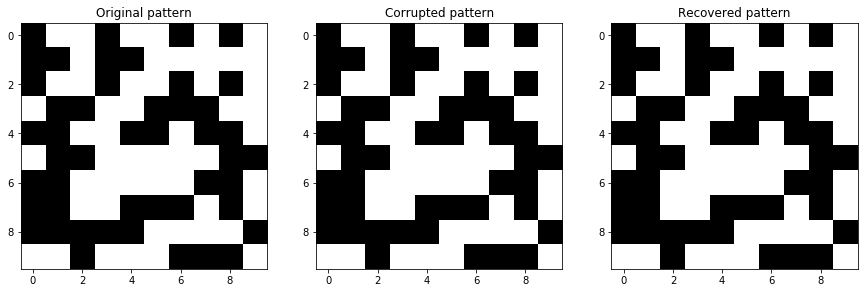

The height of the distribution is  0.5
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


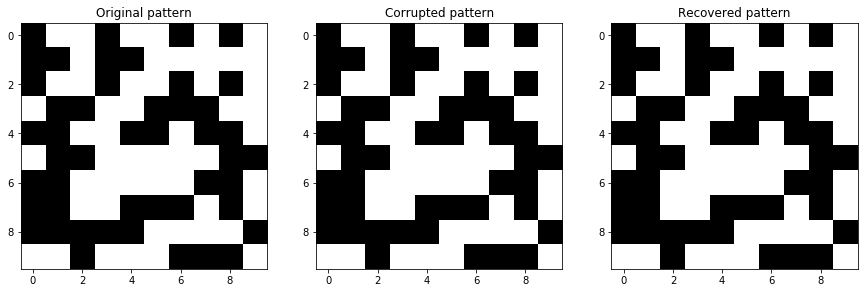

The height of the distribution is  0.6
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


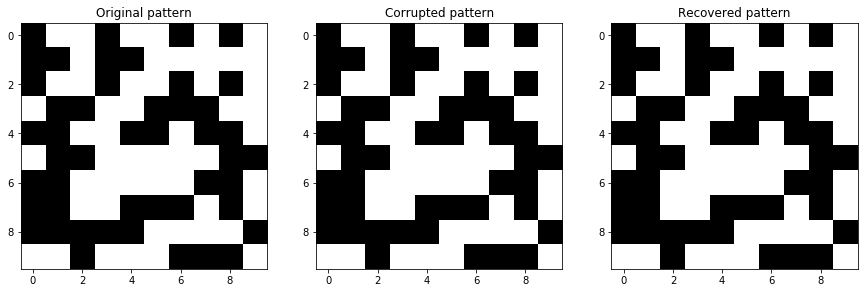

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


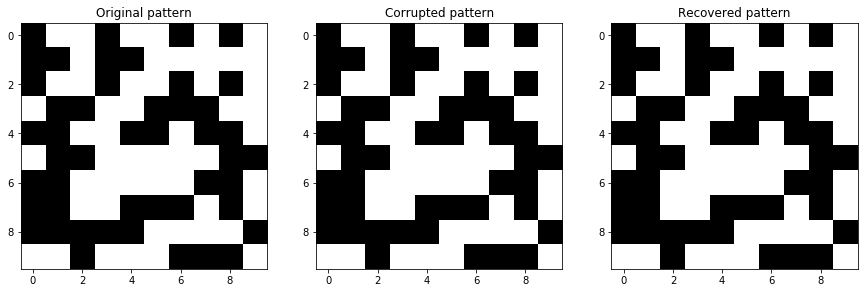

The height of the distribution is  0.8
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


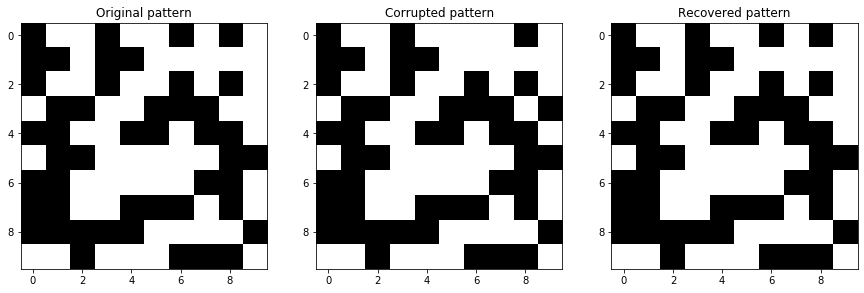

The height of the distribution is  0.9
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


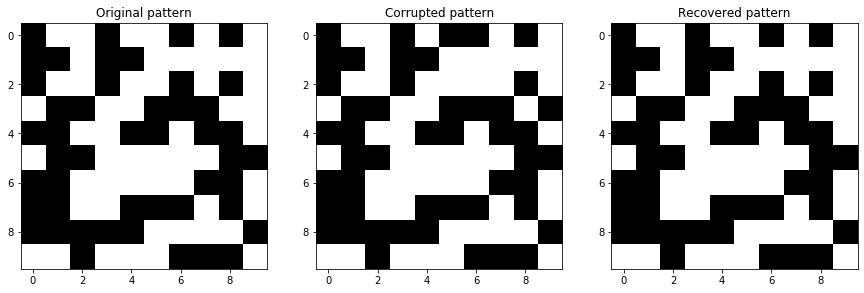

The height of the distribution is  1.0
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


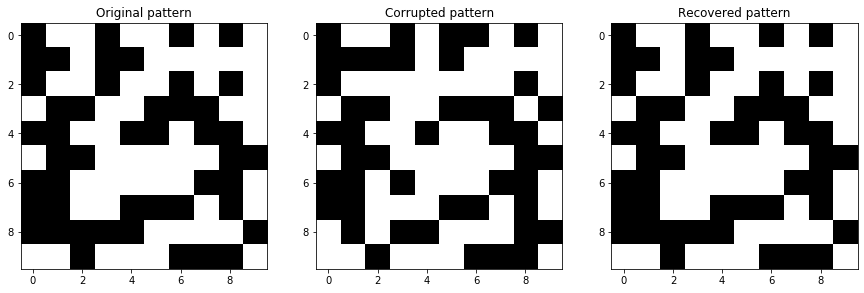

In [19]:
def corrupt_norm(sys, k, h): #k represent the mean in the gaussian
                             #h represent the height in the gaussian
    sys_temp = deepcopy(sys)
    sys_temp = sys_temp.reshape(L,L)
    N = sys.shape[0]
    for i in range(L):
        for j in range(L):
            g = gaus(k, L/5, h, i, j)
            r = np.random.rand()
            if r < g:
                sys_temp[i][j] *= -1
    return (sys_temp.reshape(1,N))[0]

idx = 1
centroids = [np.array([0,0]), np.array([0,L-1]), np.array([L-1,0]), np.array([L-1,L-1]), np.array([L//2, L//2])]
heights = np.linspace(0.1,1,10)

for k in centroids:
    print('The position of the centroid is ', k,'\n')
    for h in heights:
        print('The height of the distribution is ', h)
        yi = corrupt_norm(xi[idx], k, h)
        wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
        print('The error of the algorithm is %f' %(wrong_pixels))
        print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))
        plot(xi[idx], yi, sys)

<img src = "gaus.jpeg">

The figure shows the original pattern, the corrupted one with the centroid of the gaussian in the middle (using $h = 1$) and the recovered one. 
It can be seen that the corrupt pattern flip the pixel in the middle as we expected. On the other hand, the algorithm recover the original pattern with an error of $26\%$.

In [ ]:
# parameters 
idx = 1
heights = np.linspace(0,1,10)
centroids = [np.array([0,0]), np.array([0,L-1]), np.array([L-1,0]), np.array([L-1,L-1]), np.array([L//2, L//2])]

# Changing the height

In this section, we interpreted how the algorithm behaves when corrupting patterns using different paramenter $h$. We compare the results using MF and NMF.

In [30]:
#Variation of the error according to paramenter h using MF
MF = 0
error_NMF = [[],[], [],[], []]
i = 0
for k in centroids:

    for h in heights:
        yi = corrupt_norm(xi[idx], k, h)
        wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
        error_NMF[i].append(wrong_pixels)
    i +=1 
    


Time implement for the non mean field algorithm  of the centroids [0 0] is 2.000896453857422 [s]
Time implement for the non mean field algorithm  of the centroids [0 9] is 2.1077585220336914 [s]
Time implement for the non mean field algorithm  of the centroids [9 0] is 2.035645008087158 [s]
Time implement for the non mean field algorithm  of the centroids [9 9] is 2.1054279804229736 [s]
Time implement for the non mean field algorithm  of the centroids [5 5] is 2.2800633907318115 [s]


In [31]:
#Variation of the error according to paramenter h using NMF
MF = 1
error_MF = [[],[], [],[], []]

i = 0
for k in centroids:
    for n in 
    for h in heights:
        yi = corrupt_norm(xi[idx], k, h)
        wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
        error_MF[i].append(wrong_pixels)
    i +=1 
   

Time implement for the mean field algorithm  of the centroids [0 0] is 2.261000156402588 [s]
Time implement for the mean field algorithm  of the centroids [0 9] is 2.2332863807678223 [s]
Time implement for the mean field algorithm  of the centroids [9 0] is 2.250274896621704 [s]
Time implement for the mean field algorithm  of the centroids [9 9] is 2.274102210998535 [s]
Time implement for the mean field algorithm  of the centroids [5 5] is 2.3394274711608887 [s]


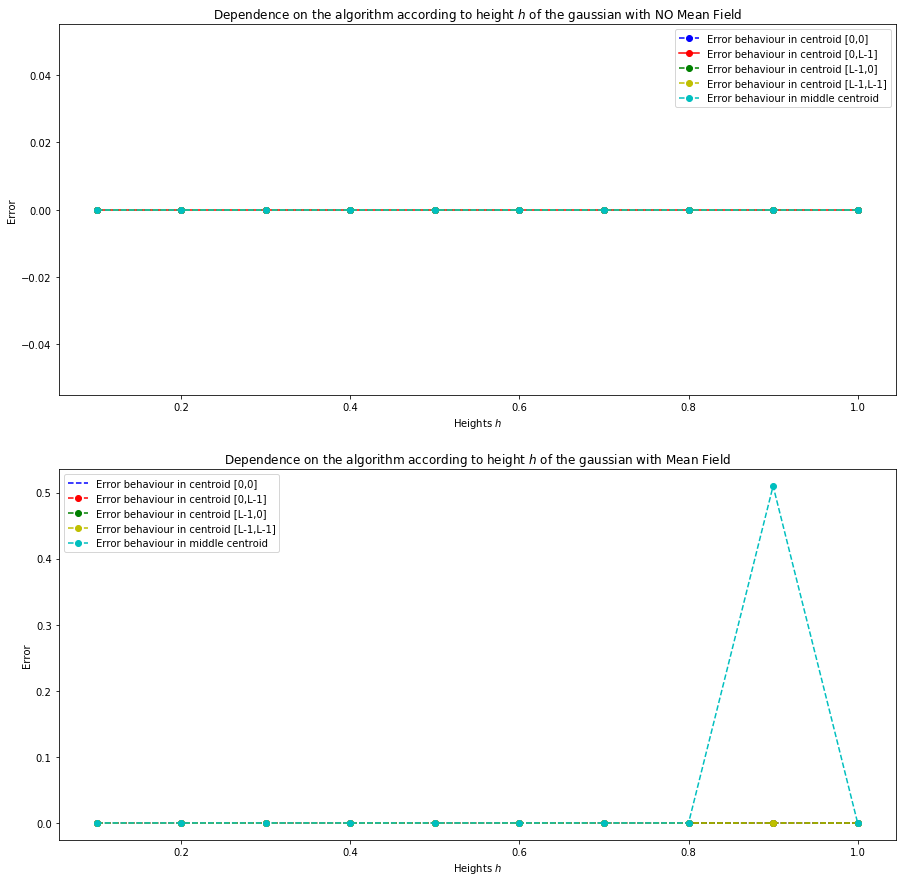

In [32]:
#plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))

ax1.plot(heights, error_NMF[0], '--bo', label ='Error behaviour in centroid [0,0]')
ax1.plot(heights, error_NMF[1], '-ro', label ='Error behaviour in centroid [0,L-1]')
ax1.plot(heights, error_NMF[2], '--go', label ='Error behaviour in centroid [L-1,0]')
ax1.plot(heights, error_NMF[3], '--yo', label ='Error behaviour in centroid [L-1,L-1]')
ax1.plot(heights, error_NMF[4], '--co', label ='Error behaviour in middle centroid')
ax1.set_title('Dependence on the algorithm according to height $h$ of the gaussian with NO Mean Field')
ax1.set_xlabel('Heights $h$')
ax1.set_ylabel('Error');
ax1.legend()


ax2.plot(heights, error_MF[0], '--b', label ='Error behaviour in centroid [0,0]')
ax2.plot(heights, error_MF[1], '--ro', label ='Error behaviour in centroid [0,L-1]')
ax2.plot(heights, error_MF[2], '--go', label ='Error behaviour in centroid [L-1,0]')
ax2.plot(heights, error_MF[3], '--yo', label ='Error behaviour in centroid [L-1,L-1]')
ax2.plot(heights, error_MF[4], '--co', label ='Error behaviour in middle centroid')
ax2.set_title('Dependence on the algorithm according to height $h$ of the gaussian with Mean Field')
ax2.set_xlabel('Heights $h$')
ax2.set_ylabel('Error');
ax2.legend()

## Cauchy noise

The Cauchy distribution is given by:
$$
\\
\mathcal{C}(x) = h \cdot \left(1 + \left(\frac{x- x_0}{\gamma}\right)^2 \right)^{-1}
\\
$$
where $h$ is the maximum height of the distribution, $x_{0}$ specifies the location of the peak of the distribution, and $\gamma$ is the scale parameter which specifies the half-width at half-maximum (HWHM).

We chose $\gamma$ arbitrary ($\gamma = L/5$) and made the peak $x_0$ of the distribution and its height $h$ variable.

We followed the same approach we used for the gaussian noise: we overlapped a 2-dimensional Cauchy distribution, and we used it to have a variable threshold. Then we generated corrupted patterns, recovered them and evaluated the error.


In [21]:
def cauchy(mu, gamma, h, x, y):#mu is a 2d array representing the position of the median
                               #h is the maximum height of the distribution     
    h = np.sqrt(h)
    c_x = h/(1 + (((x-mu[0]))/gamma)**2)
    c_y = h/(1 + (((y-mu[1]))/gamma)**2)
    c = c_y * c_x
    return c

The position of the median is  [0 0] 

The height of the distribution is  0.1
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


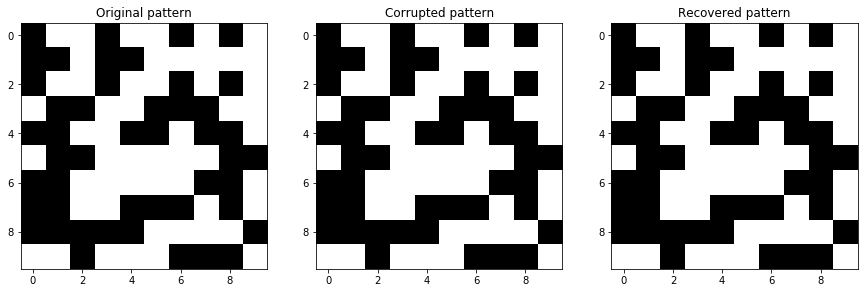

The height of the distribution is  0.2
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


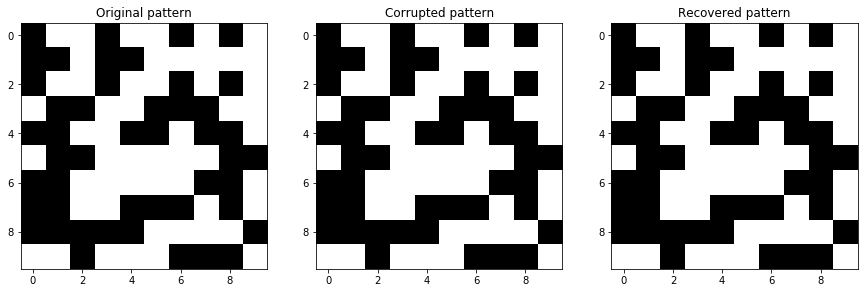

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


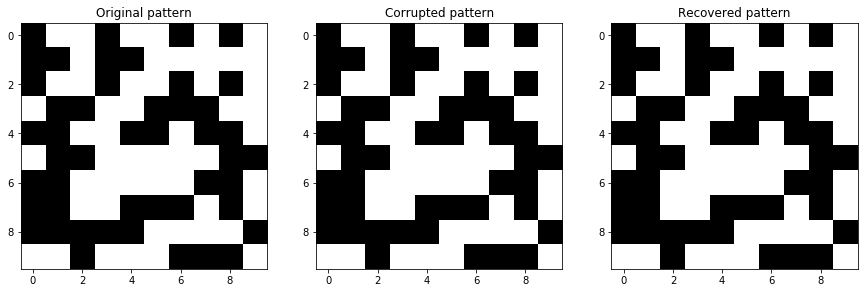

The height of the distribution is  0.4
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


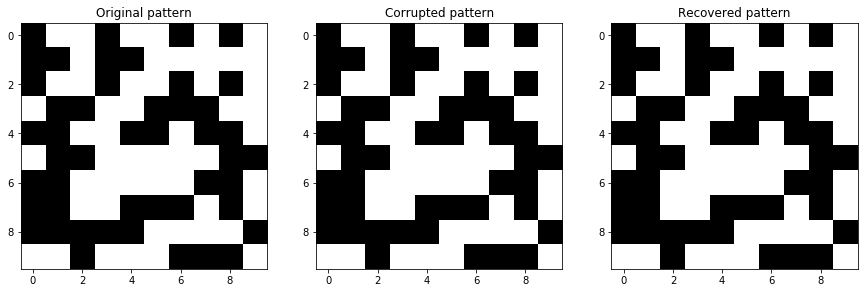

The height of the distribution is  0.5
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


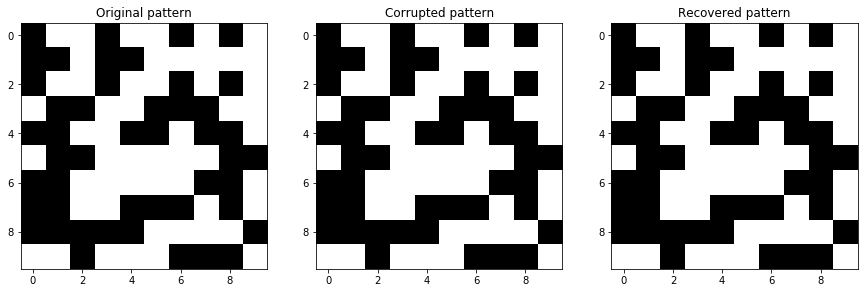

The height of the distribution is  0.6
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


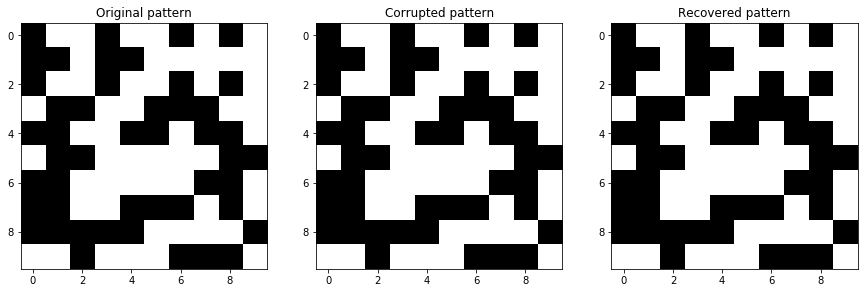

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


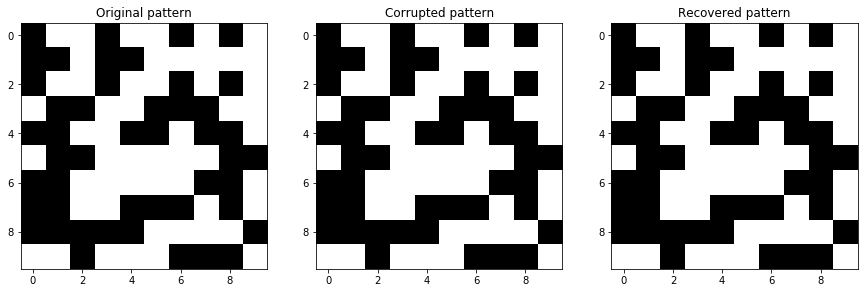

The height of the distribution is  0.8
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


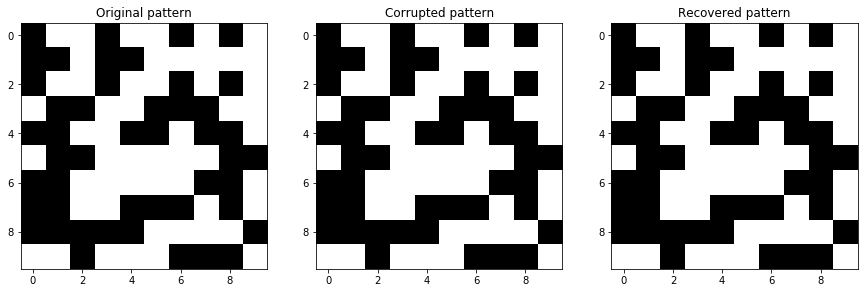

The height of the distribution is  0.9
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


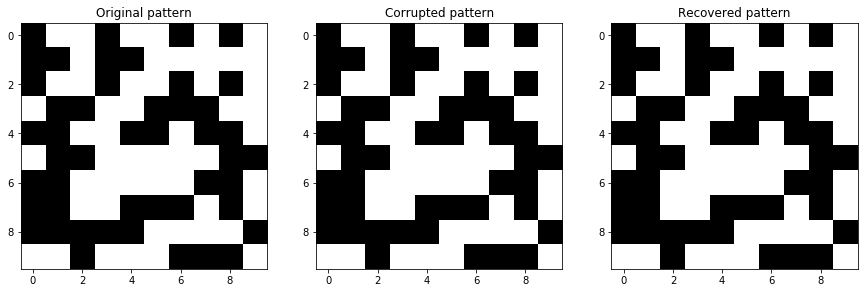

The height of the distribution is  1.0
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


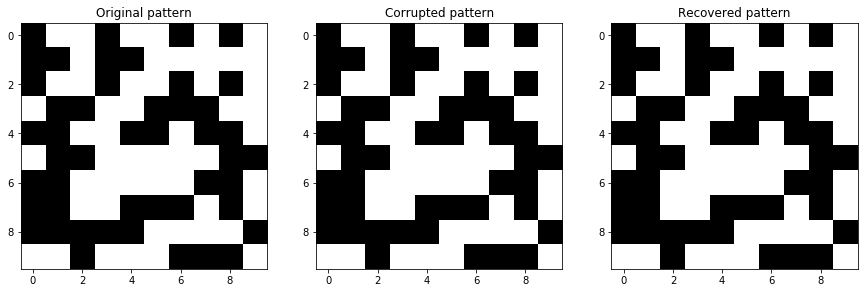

The position of the median is  [0 9] 

The height of the distribution is  0.1
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


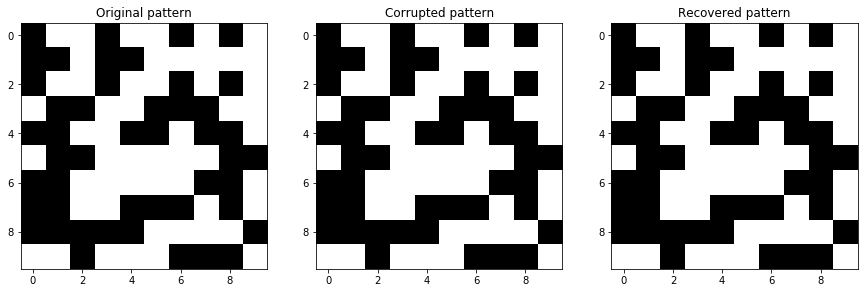

The height of the distribution is  0.2
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


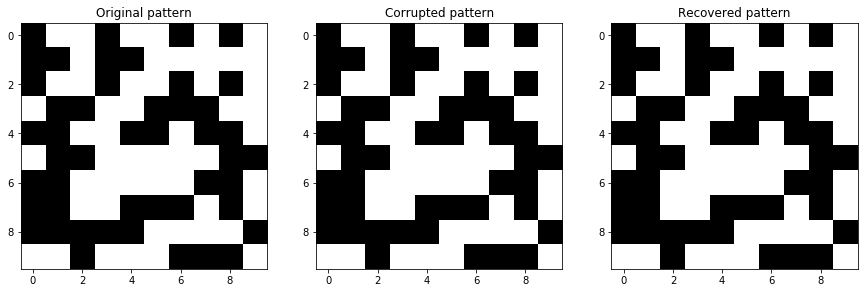

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


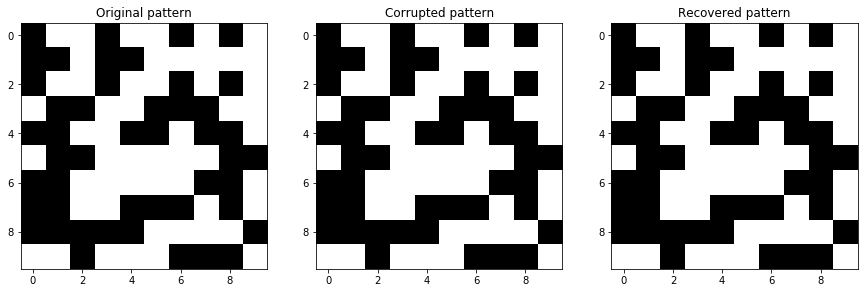

The height of the distribution is  0.4
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


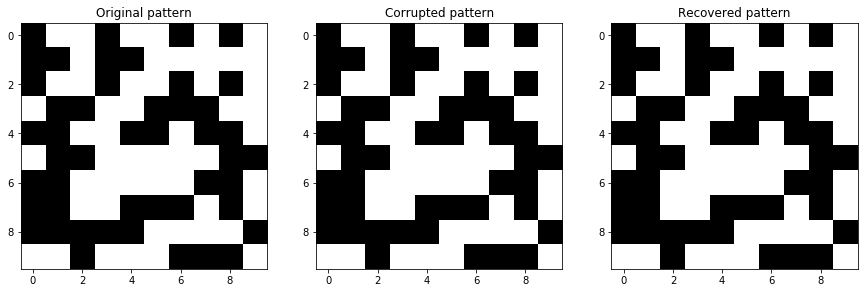

The height of the distribution is  0.5
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


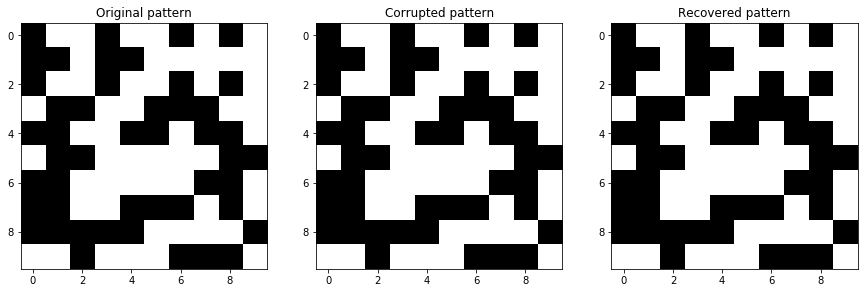

The height of the distribution is  0.6
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


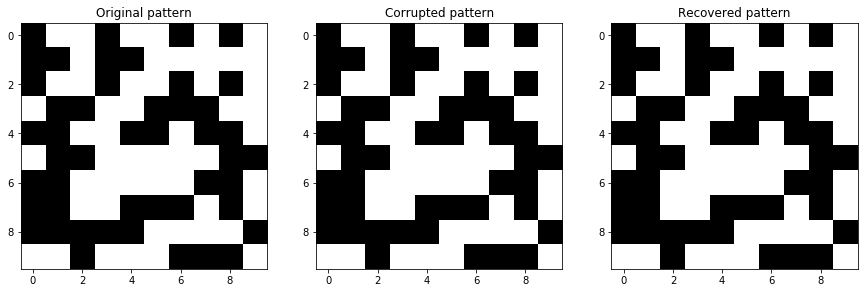

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


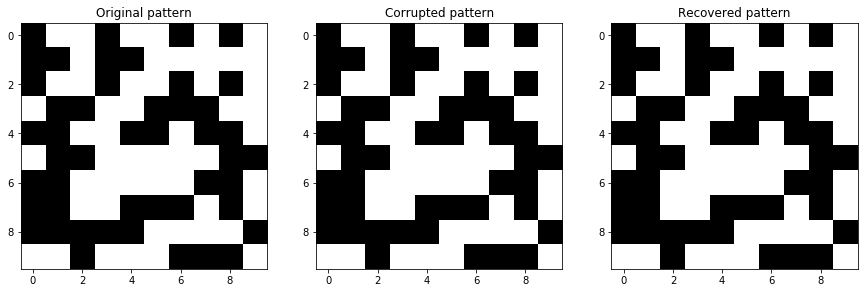

The height of the distribution is  0.8
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


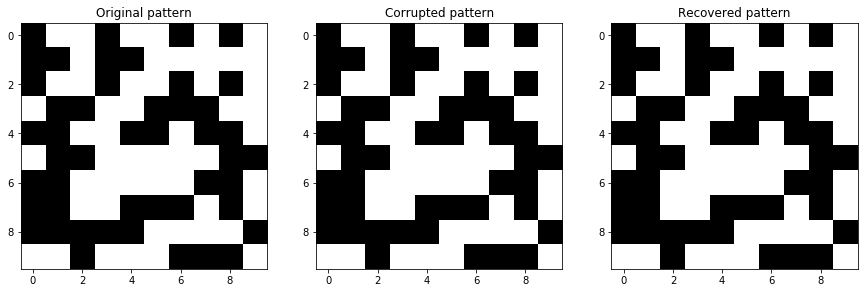

The height of the distribution is  0.9
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


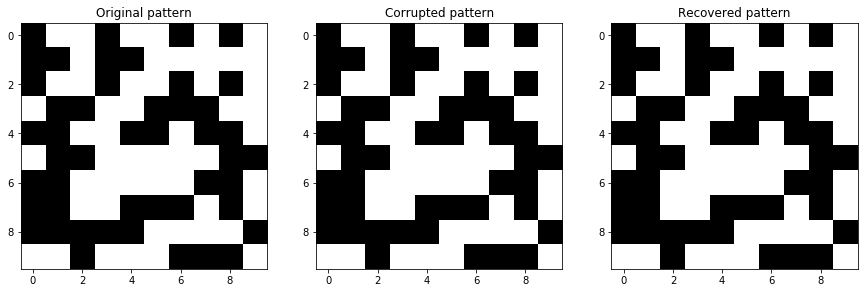

The height of the distribution is  1.0
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


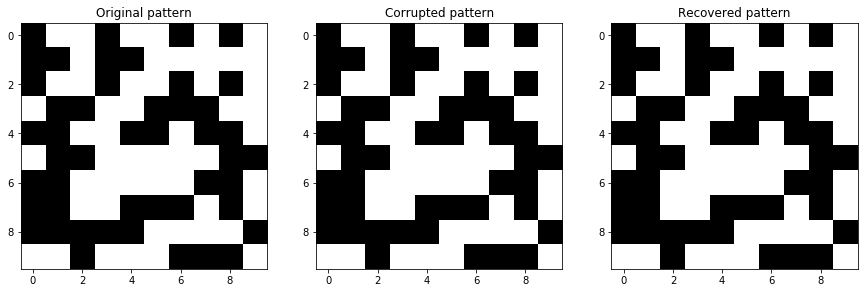

The position of the median is  [9 0] 

The height of the distribution is  0.1
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


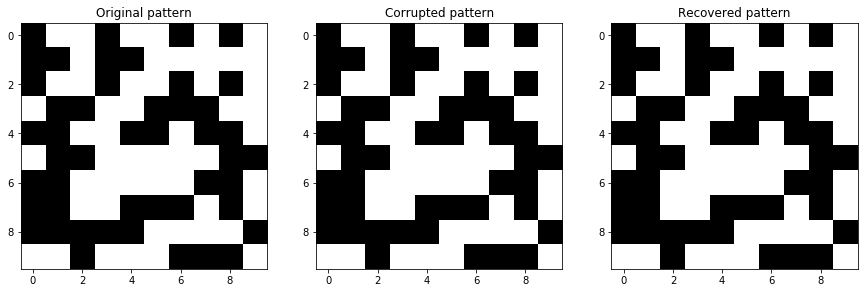

The height of the distribution is  0.2
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


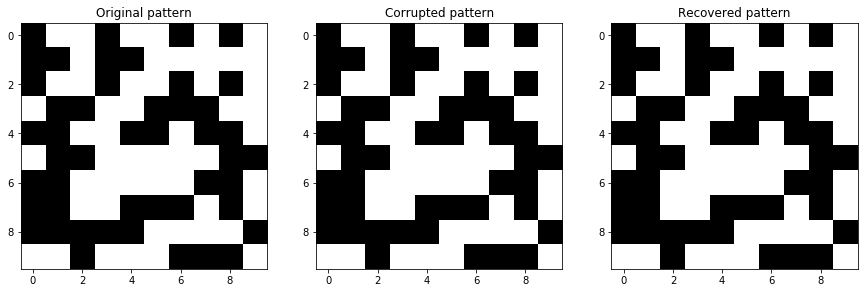

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


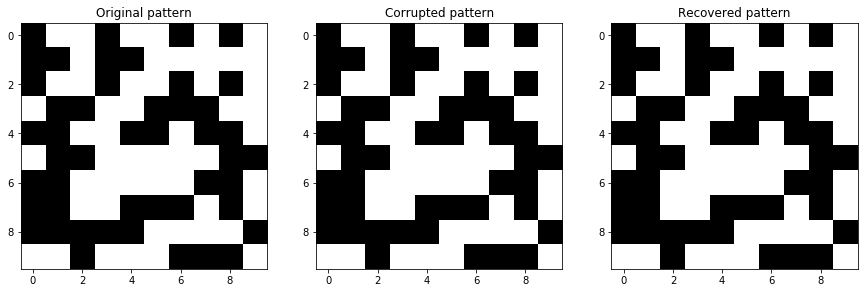

The height of the distribution is  0.4
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


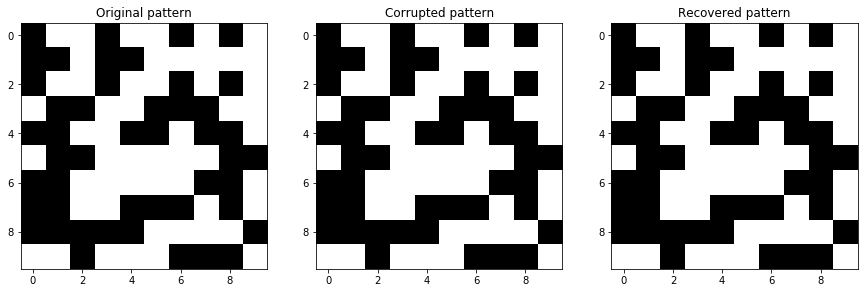

The height of the distribution is  0.5
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


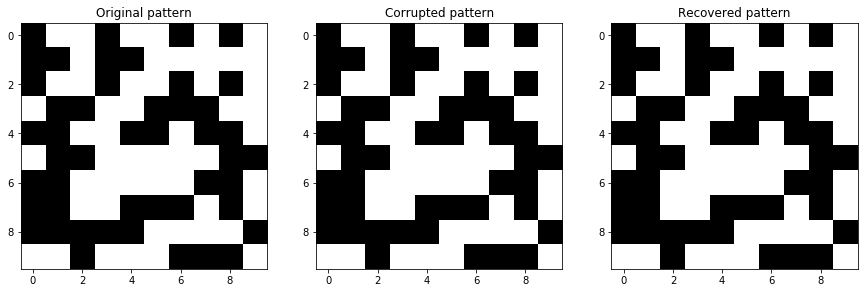

The height of the distribution is  0.6
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


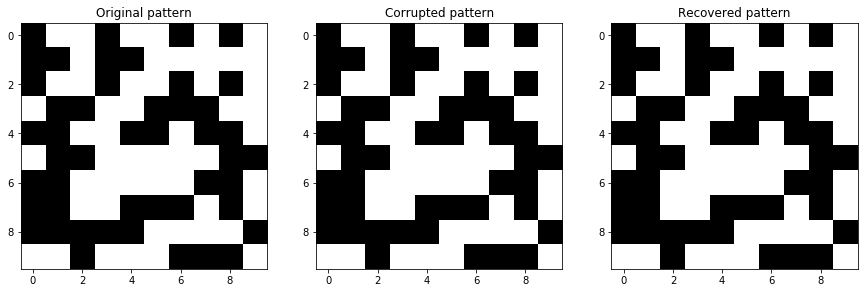

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


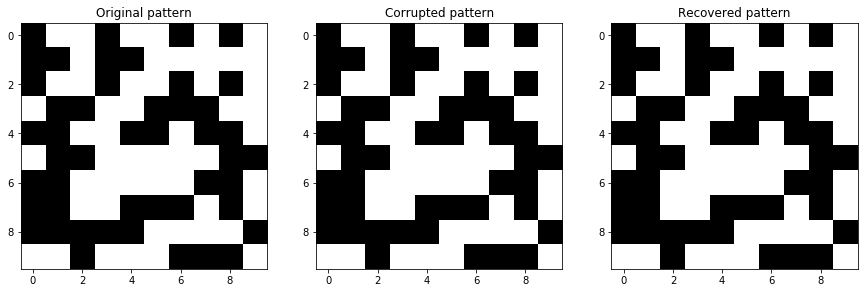

The height of the distribution is  0.8
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


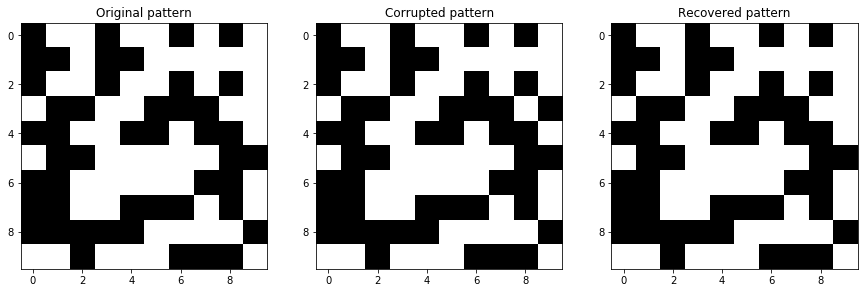

The height of the distribution is  0.9
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


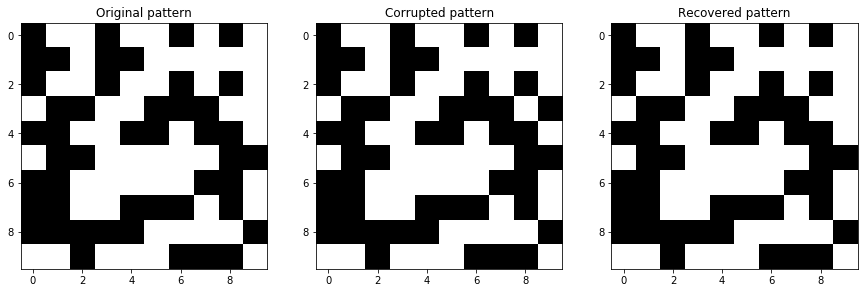

The height of the distribution is  1.0
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


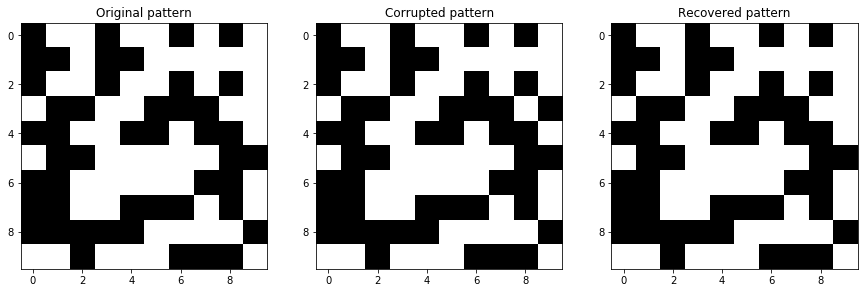

The position of the median is  [9 9] 

The height of the distribution is  0.1
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


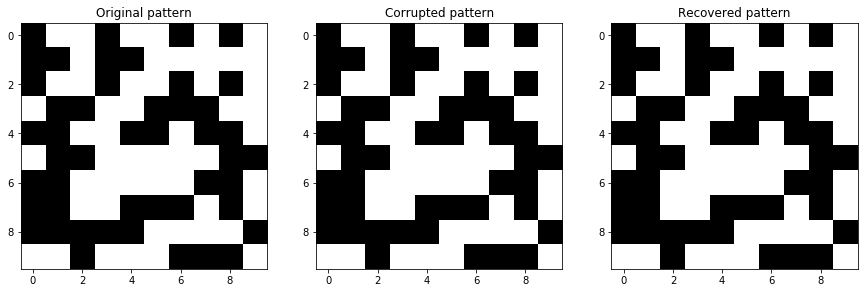

The height of the distribution is  0.2
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


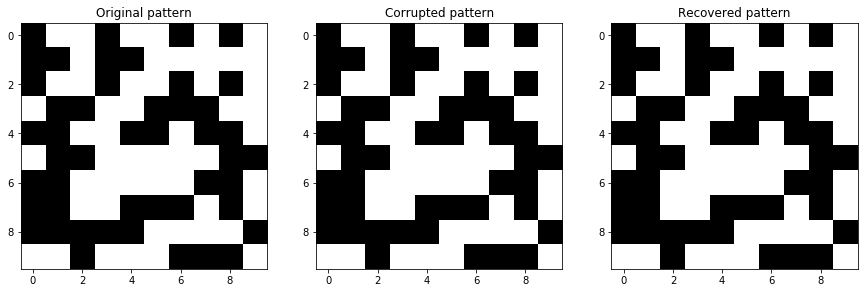

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


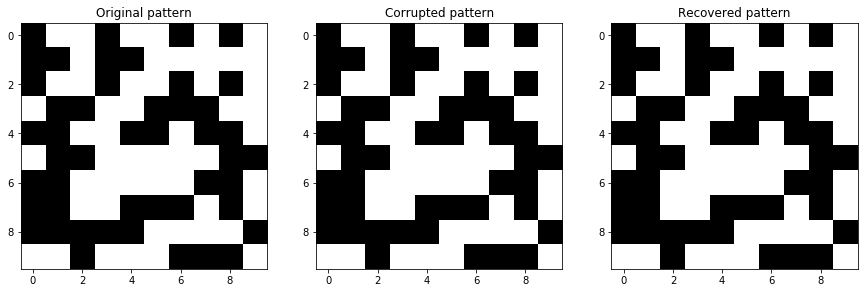

The height of the distribution is  0.4
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


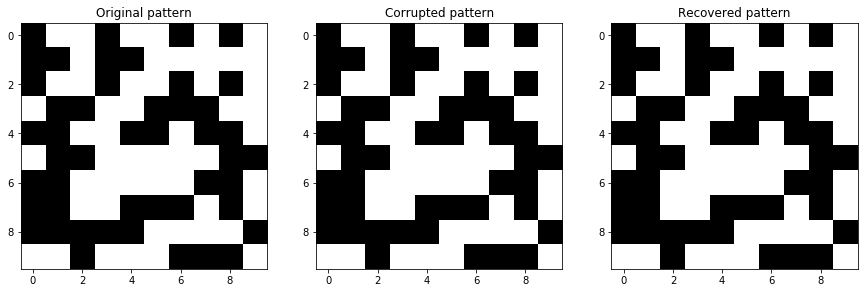

The height of the distribution is  0.5
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


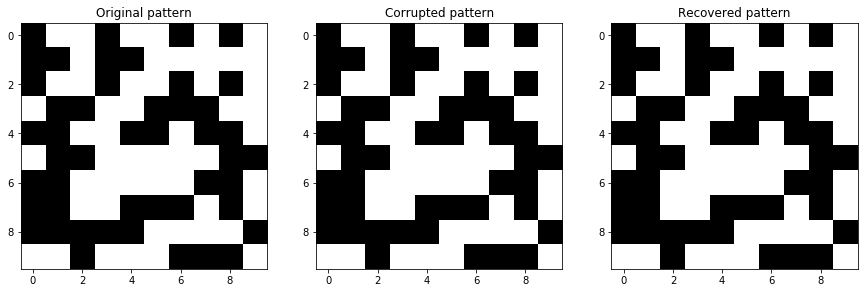

The height of the distribution is  0.6
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


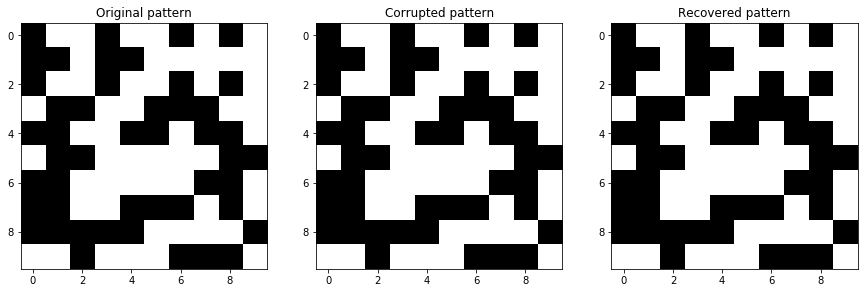

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


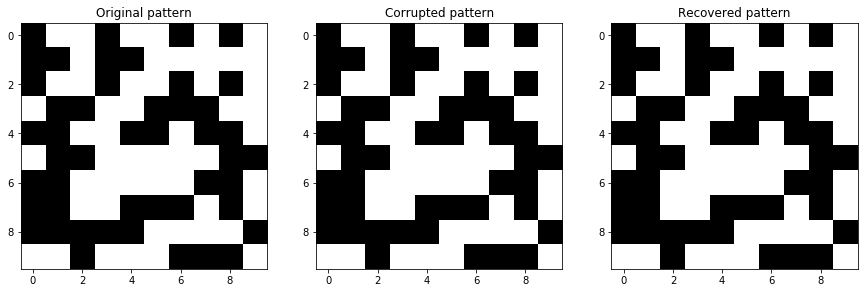

The height of the distribution is  0.8
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


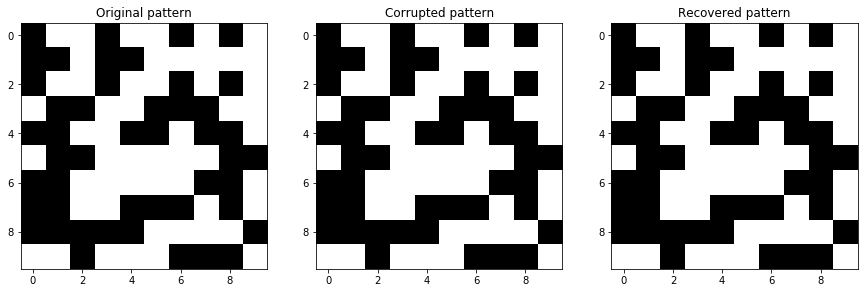

The height of the distribution is  0.9
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


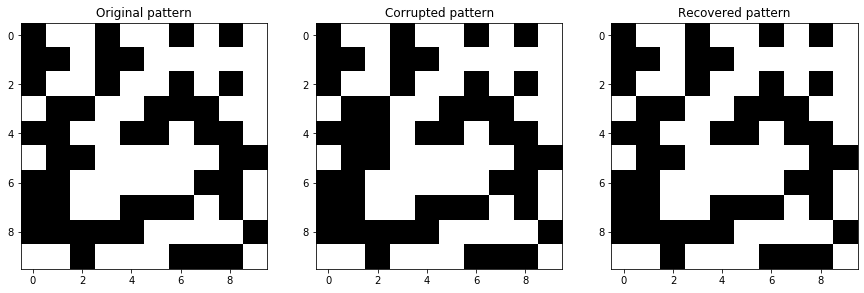

The height of the distribution is  1.0
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


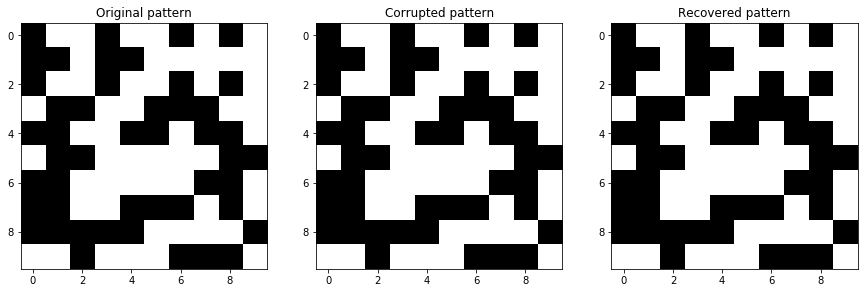

The position of the median is  [5 5] 

The height of the distribution is  0.1
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


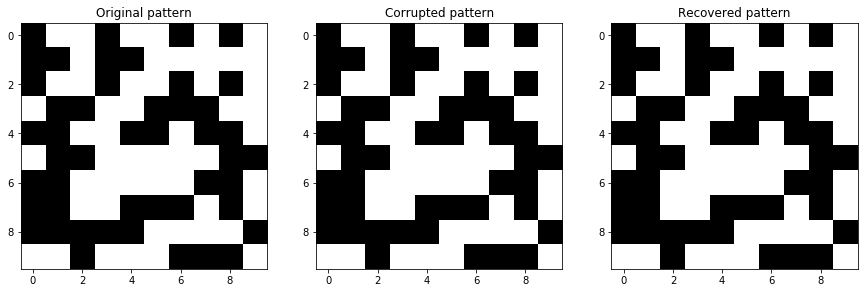

The height of the distribution is  0.2
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


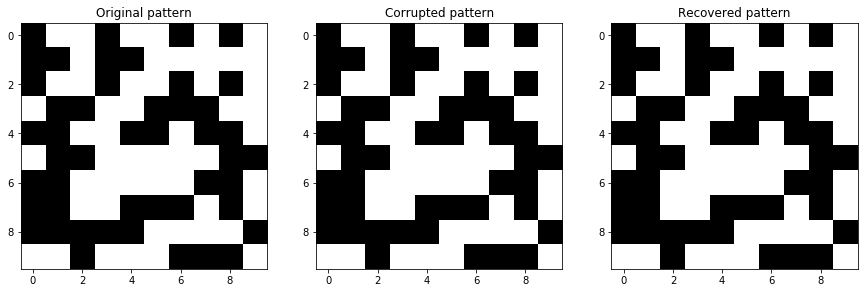

The height of the distribution is  0.30000000000000004
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


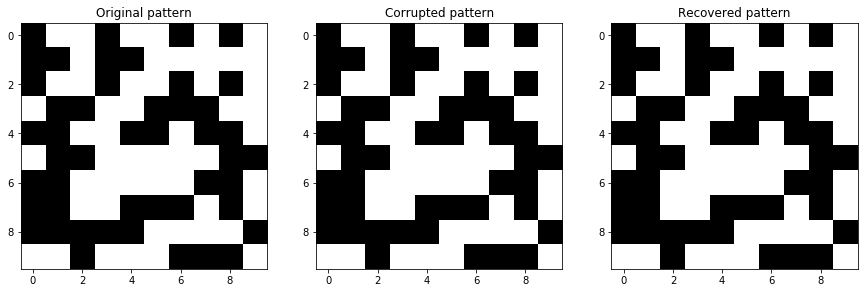

The height of the distribution is  0.4
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


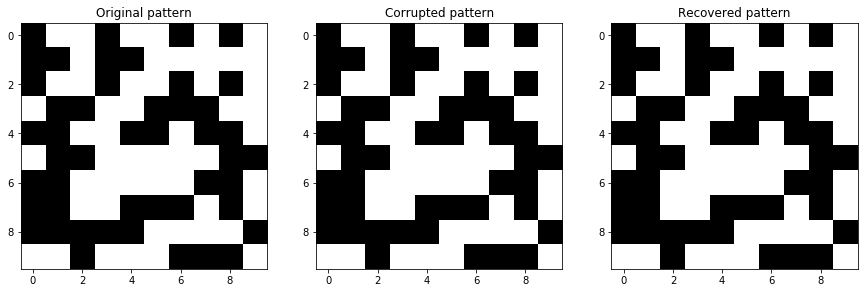

The height of the distribution is  0.5
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


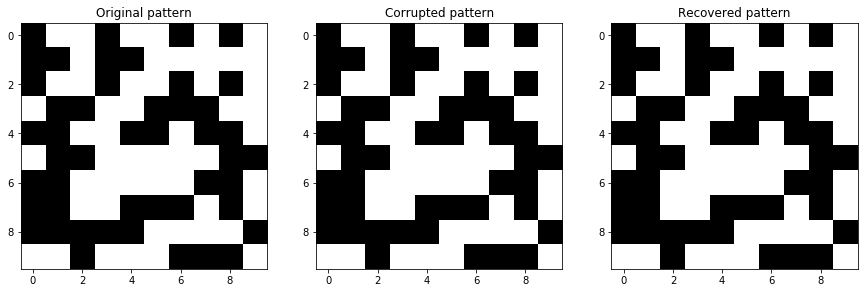

The height of the distribution is  0.6
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


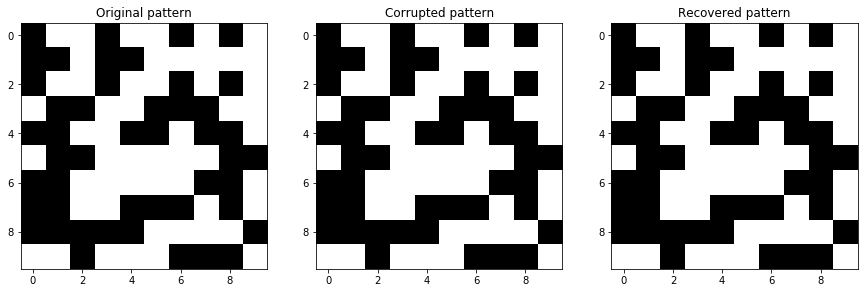

The height of the distribution is  0.7000000000000001
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


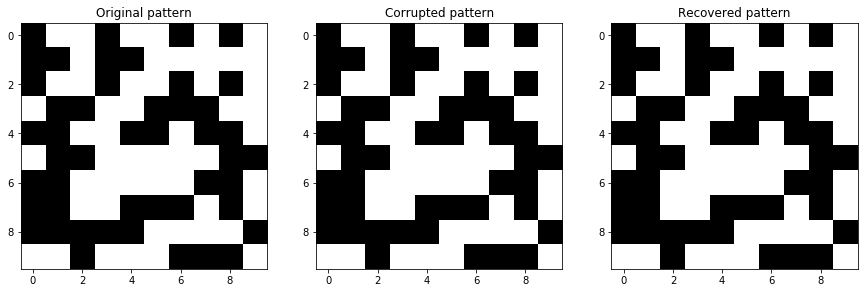

The height of the distribution is  0.8
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


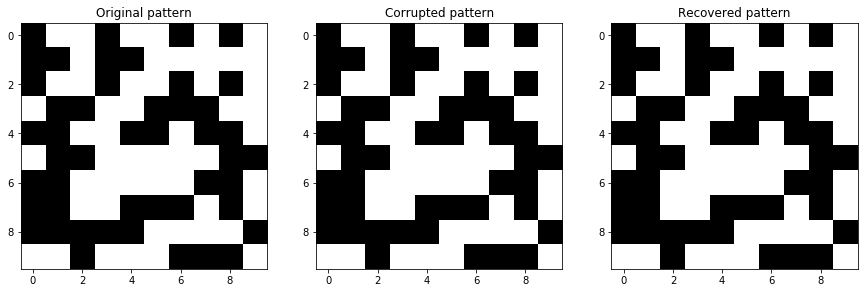

The height of the distribution is  0.9
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


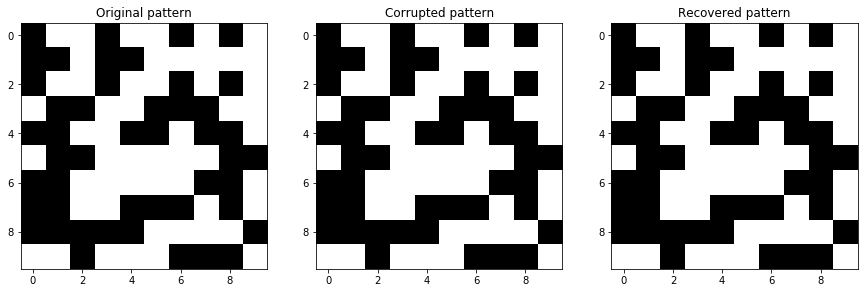

The height of the distribution is  1.0
The error of the algorithm is 0.000000
The algorithm recognised the pattern 1 and the correct pattern is 1


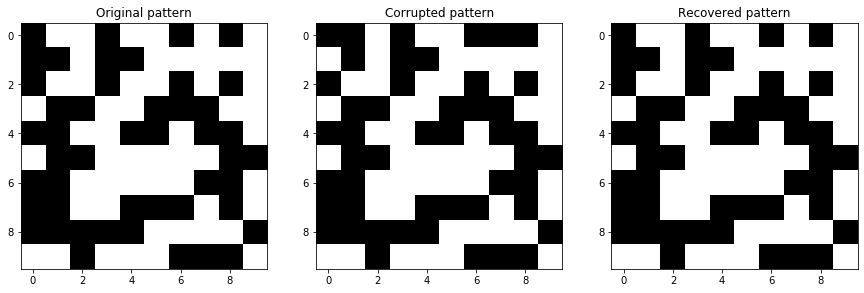

In [22]:
def corrupt_cauchy(sys, k, h): #k represent the mean in the gaussian
                               #h represent the height in the gaussian
    sys_temp = deepcopy(sys)
    sys_temp = sys_temp.reshape(L,L)
    N = sys.shape[0]
    for i in range(L):
        for j in range(L):
            g = cauchy(k, L/5, h, i, j)
            r = np.random.rand()
            if r < g:
                sys_temp[i][j] *= -1
    return (sys_temp.reshape(1,N))[0]

idx = 1
centroids = [np.array([0,0]), np.array([0,L-1]), np.array([L-1,0]), np.array([L-1,L-1]), np.array([L//2, L//2])]
heights = np.linspace(0.1,1,10)

for k in centroids:
    print('The position of the median is ', k,'\n')
    for h in heights:
        print('The height of the distribution is ', h)
        yi = corrupt_cauchy(xi[idx], k, h)
        wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
        print('The error of the algorithm is %f' %(wrong_pixels))
        print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))
        plot(xi[idx], yi, sys)
        

<img src = "cauchy.jpeg">

The figure shows the original pattern, the corrupted one with the centroid of the cauchy in the middle (using $h = 0.1$) and the recovered one. 

As we expected, the flipped pixel are mostly in the middle. In this case, the algorithm recover the original pattern with an error of $4\%$.


In [33]:
# gaussian corrupt error behaviour with mean field changing the parameter height on the gaussian
MF = 1
error_MF = [[],[], [],[], []]

i = 0
for k in centroids:
    for h in heights:
        start_time = time.time()
        yi = corrupt_cauchy(xi[idx], k, h)
        wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
        error_MF[i].append(wrong_pixels)
    i +=1 
    end_time = time.time()
   # print('Time implement for the mean field algorithm  of the centroids', k, 'is', end_time - start_time, '[s]')
    

In [34]:
# gaussian corrupt error behaviour with non mean field changing the parameter height on the gaussian
MF = 0
error_NMF = [[],[], [],[], []]

i = 0
for k in centroids:
    start_time = time.time()
    for h in heights:
        yi = corrupt_cauchy(xi[idx], k, h)
        wrong_pixels, assigned_pattern, sys = algorithm(xi, idx, yi)
        error_NMF[i].append(wrong_pixels)
    i +=1 
    end_time = time.time()
    #print('Time implement for the non mean field algorithm  of the centroids', k, 'is', end_time - start_time, '[s]')
    

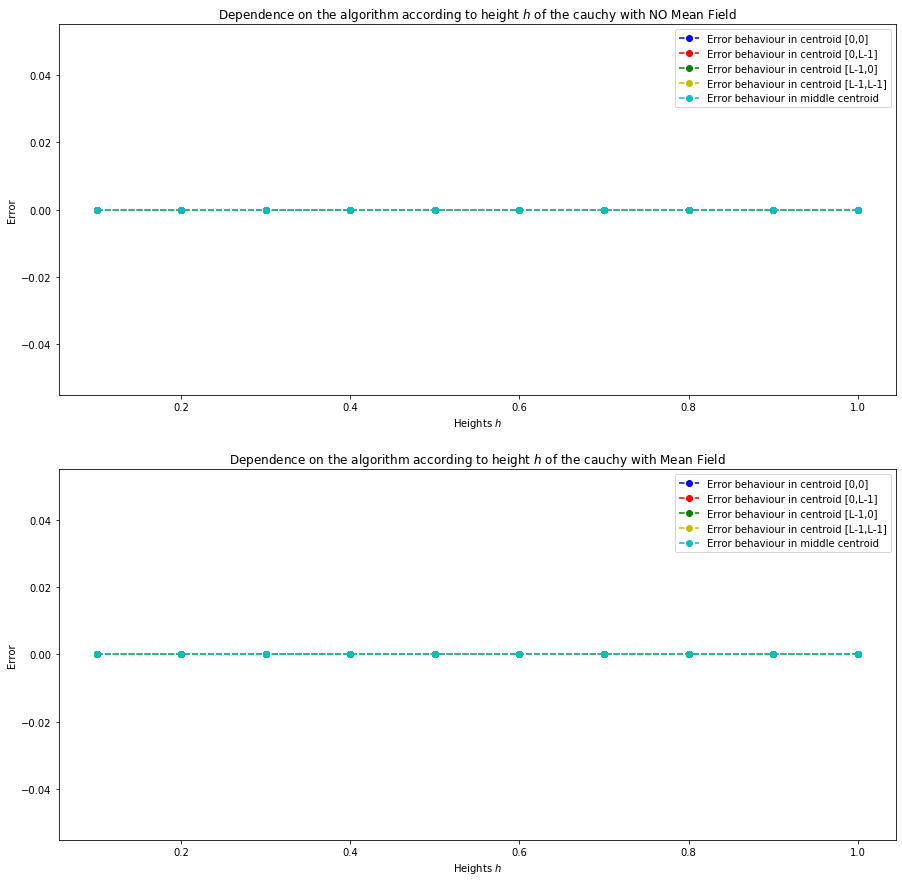

In [35]:
#plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))

ax1.plot(heights, error_NMF[0], '--bo', label ='Error behaviour in centroid [0,0]')
ax1.plot(heights, error_NMF[1], '--ro', label ='Error behaviour in centroid [0,L-1]')
ax1.plot(heights, error_NMF[2], '--go', label ='Error behaviour in centroid [L-1,0]')
ax1.plot(heights, error_NMF[3], '--yo', label ='Error behaviour in centroid [L-1,L-1]')
ax1.plot(heights, error_NMF[4], '--co', label ='Error behaviour in middle centroid')
ax1.set_title('Dependence on the algorithm according to height $h$ of the cauchy with NO Mean Field')
ax1.set_xlabel('Heights $h$')
ax1.set_ylabel('Error');
ax1.legend()


ax2.plot(heights, error_MF[0], '--bo', label ='Error behaviour in centroid [0,0]')
ax2.plot(heights, error_MF[1], '--ro', label ='Error behaviour in centroid [0,L-1]')
ax2.plot(heights, error_MF[2], '--go', label ='Error behaviour in centroid [L-1,0]')
ax2.plot(heights, error_MF[3], '--yo', label ='Error behaviour in centroid [L-1,L-1]')
ax2.plot(heights, error_MF[4], '--co', label ='Error behaviour in middle centroid')
ax2.set_title('Dependence on the algorithm according to height $h$ of the cauchy with Mean Field')
ax2.set_xlabel('Heights $h$')
ax2.set_ylabel('Error');
ax2.legend()

In general the algorithm behaves the same for each given height and different centroids for the M Field while changes are observed for the N M Field which shows the instability of the algorithm. In all cases,  the error flactuates with  the given height h, showing the instability of the algorithm. In the centroid [L-1, L-1], the error is maximum in  (0.5 , 0.6) and (0.6 , 0,7) meaning that at at the middle of the height, the algorithms generated more errors (which could be the average error) compared to other extremes.  

---to be continued

# Montecarlo simulation
As we have stated before a really interesting feature of the hopfield model is that it gives us the possibility of mapping a neuron system into a spin glasses system. 

We can employ technics developed to study physical systems to use the hopfield model in an optimized way. We will learn below that we can pass from an algorithm that takes $O(N^2t)$ operation, with $N$ size of the system and $t$ the number of iteration of the update rule, to an algorithm that takes $O(Nt)$ operation for the Mean Field case, or even less in the Non-MF case.

Montecarlo simulations are simulation that uses pseudorandom number to simulate a physical system. For this particular task we aim at finding the ground state of a spin system using the metropolis algorithm as an update rule. 

Given the system energy $\mathcal{H}$ we randomly flip a spin of the system and we compute the difference in energy $\Delta\mathcal{H}=\mathcal{H}_{f}-\mathcal{H}_{i}$. Then accept the updated system with the following probability:
$$
\begin{equation}
p_{acc}= \min\left( 1, e^{-\beta\Delta\mathcal{H}} \right)
\end{equation}
$$
where $\beta=(K_{b}T)^{-1}$ is the inverse of the size of the system. In this way if the energy is decreasing we update the system with probability 1, and if it is greater with a probability proportional to the increase in energy.

From the theory we know that the critical temperature, the highest temperature at which the system is trapped in the minima, is $T=1/K_b$.

In this section we will cover:
- The stability of the Montecarlo methods;
- The improvement in the time implementation of Montecarlo;
- The dependance of the algorithm's performances w.r.t. the type of noise;
- The dependance of the algorithm's performances w.r.t. the number of neighbors for the NON-MF version;

In [ ]:
def H(J,sys):
    N = sys.shape[0]
    energy = 0
    for i in range(N):
        for j in range(i):
            energy -= J[i][j]*sys[i]*sys[j]
    return energy

# Mean Field version of dH
def dH(J, sys, k): # k is the index of the spin flipped
    N = sys.shape[0]
    dh = 0
    for i in range(N):
        dh += sys[i]*J[k][i]
    dh *= 2*sys[k]
    return dh

def metropolis(J, sys1, k, B): # B = 1/kbT temperature of the system
    sys = deepcopy(sys1)
    dh = dH(J, sys, k)
    r = np.random.rand() # random variable between (0,1)
    if r < np.exp( -B*dh ):
        sys[k] = -sys[k]
    return sys
    
def montecarlo(J, sys1, B, t ): # t number of iteration of the montecarlo
    sys = deepcopy(sys1)
    N = sys.shape[0]
    for i in range(t):
        k = np.random.randint(0,N)
        sys = metropolis(J, sys, k, B)
    return sys

## Mean field Montecarlo

In [ ]:
xi = random_patterns(N,p)
J = MF_coupling(xi,N)

### Stability

In [ ]:
idx = np.random.randint(10)

sys = montecarlo(J,xi[idx], 10, 1000)
wrong_pixels = error_im(xi[idx],sys)
assigned_pattern = assign_pattern(xi,sys)


fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].set_title('Pattern')
ax[0].imshow(xi[idx].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

Stability for different temperature, $\beta=[0,1,10,25,50,100]$ with $t=1000$ and $L=10$ fixed. <br>
Each point $100$ iteration.

In [ ]:
beta = [0, 1, 10, 25, 50, 100]
err_beta_mean = []
err_beta_std = []
success = []
for b in beta:
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        sys = montecarlo(J,xi[idx], b, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_beta_mean.append( errors.mean() )
    err_beta_std.append( errors.std() )
    success.append(correct)
    
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of T')
ax[0].set_xlabel('Beta [$J^{-1}$]')
ax[0].set_ylabel('Average error')
ax[0].plot(beta, err_beta_mean, '--bo', label='Error')
ax[0].errorbar(beta,err_beta_mean, yerr=err_beta_std,ecolor='red', label='Fluctuation of error',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of T')
ax[1].set_xlabel('Beta [$J^{-1}$]')
ax[1].set_ylabel('Probability of success')
ax[1].plot(beta, success, '--ro', label='Data')
ax[1].legend()

<img src = ".\Images\m_avge_beta.png">

We can see how a higher value of $\beta$ leads to  higher probability of success, and a $\beta<10$ lends to totally unacceptable results.

Even if the results with $\beta>25$ seems to produce better results we have to think on the functioning of the algorithm: with very high beta the probability of flipping a "wrong" spin is $\sim0$ and, starting from a minima, it probably means that it does not flip a spin at all. So, for the following analisys we will use $\beta=10$.

Stability w.r.t the number of iterations $t=[10,25,50,100,200,500,750,1000,1250,1500,1750,2000]$ with $\beta=[10,25]$ and $L=10$ fixed. Each point is obtained after compilation of the algorithm 100 times.

In [ ]:
# Beta = 10
iterations=[10,25,50,100,200,500,750,1000,1250,1500,1750,2000]
err_t_mean = []
err_t_std = []
success_t = []
for t in iterations:
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        sys = montecarlo(J,xi[idx], 10, t)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_t_mean.append( errors.mean() )
    err_t_std.append( errors.std() )
    success_t.append(correct)

In [ ]:
# beta = 25
err_t1_mean = []
err_t1_std = []
success_t1 = []
for t in iterations:
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        sys = montecarlo(J,xi[idx], 25, t)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_t1_mean.append( errors.mean() )
    err_t1_std.append( errors.std() )
    success_t1.append(correct)

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of iterations')
ax[0].set_xlabel('Number of iteration t')
ax[0].set_ylabel('Average error')
ax[0].plot(iterations, err_t_mean, '--bo', label='Error with beta=10')
ax[0].errorbar(iterations,err_t_mean, yerr=err_t_std,ecolor='blue',fmt='none')
ax[0].plot(iterations, err_t1_mean, '--go', label='Error with beta=25')
ax[0].errorbar(iterations,err_t1_mean, yerr=err_t1_std,ecolor='green',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of the number of iterations t')
ax[1].set_xlabel('Number of iteration t')
ax[1].set_ylabel('Probability of success')
ax[1].plot(iterations, success_t, '--bo', label='Data with beta=10')
ax[1].plot(iterations, success_t1, '--go', label='Data with beta=25')
ax[1].legend()

<img src = ".\Images\m_s_iterations.png">

As we can expect, the number of iterations, in this case, actually increase the error of the algorithm. It is predictable since we already start from the correct pattern and adding iterations only increase the probability of flipping some random spin. We have also choosen a $\beta=10$, that lends to a unstable situation. We can repeat the experiment with $\beta=25$ to see if there is an improvement is achieved.

The important thing to notice is that with $\beta=10$ the error reaches a plateau, but not the probability of success.

Instead with $\beta=25$ both error and probability of success seems to reach a plateau. So in the following we will use $25$ as the value of $\beta$.

In [1]:
errors = []
correct = 0
for j in range(100):
    idx = np.random.randint(10)
    sys = montecarlo(J,xi[idx], 10, 1000)
    wrong_pixels = error_im(xi[idx],sys)
    assigned_pattern = assign_pattern(xi,sys)
    
    if idx == assigned_pattern: correct += 1
    errors.append(wrong_pixels) 
    
correct /= 100
errors = np.array(errors)
print(correct)
print(errors.mean())
    

NameError: name 'np' is not defined

ISN'T IT SOMETHING MISSING HERE?

### Corruption with uniform noise

In [ ]:
idx = 3

yi = corrupt_uniform(xi[idx], 0.35)

sys = montecarlo(J,yi, 10, 100)
wrong_pixels = error_im(xi[idx],sys)
assigned_pattern = assign_pattern(xi,sys)


fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].set_title('Pattern')
ax[0].imshow(xi[idx].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

Analysis of the dependance of temperature with the stability of the algorithm with uniformly corrupted patterns with $q=0.2$.

In [ ]:
beta = [0, 1, 10, 25, 50, 100]
err_beta_mean_c = []
err_beta_std_c = []
success_beta_c = []
for b in beta:
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_uniform(xi[idx], 0.2)
        sys = montecarlo(J, yi, b, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_beta_mean_c.append( errors.mean() )
    err_beta_std_c.append( errors.std() )
    success_beta_c.append(correct)

fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of T with uniform noise')
ax[0].set_xlabel('Beta [$J^{-1}$]')
ax[0].set_ylabel('Average error')
ax[0].plot(beta, err_beta_mean_c, '--bo', label='Error')
ax[0].errorbar(beta,err_beta_mean_c, yerr=err_beta_std_c,ecolor='red', label='Fluctuation of error',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of T with uniform noise')
ax[1].set_xlabel('Beta [$J^{-1}$]')
ax[1].set_ylabel('Probability of success')
ax[1].plot(beta, success_beta_c, '--ro', label='Data')
ax[1].legend()

<img src = ".\Images\m_c_beta.png">

As stated above even here we can say that the best temperature for the stability of the algorithm is when $\beta\geq 25$,and so from now on we will use that parameter. Here the result is even more important since we don't start from an original pattern but from a corrupted pattern.

In [ ]:
iterations = [10,25,50,100,200,500,750,1000,1250,1500,1750,2000]
err_t_mean_c = []
err_t_std_c = []
success_t_c = []
for t in iterations:
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_uniform(xi[idx], 0.2)
        sys = montecarlo(J, yi, 25, t)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_t_mean_c.append( errors.mean() )
    err_t_std_c.append( errors.std() )
    success_t_c.append(correct)
    
    
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of iterations')
ax[0].set_xlabel('Number of iteration t')
ax[0].set_ylabel('Average error')
ax[0].plot(iterations, err_t_mean_c, '--bo', label='Errors')
ax[0].errorbar(iterations,err_t_mean_c, yerr=err_t_std_c, ecolor='blue',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of the number of iterations t')
ax[1].set_xlabel('Number of iteration t')
ax[1].set_ylabel('Probability of success')
ax[1].plot(iterations, success_t_c, '--bo', label='Data')
ax[1].legend()

<img src=".\Images\m_c_iter.png">

The behaviour is not clear, maybe it requires a number of tests and observations, but it seem to reach an oscillatory behaviour after $t=1000$, but in order to obtain better results one could use $t=500$. <br>
Last but not least, we try with $t=500$, $\beta=25$ and $q$ = $[0.1,1]$ in steps of $0.1$

In [ ]:
prob = np.linspace(0,1,10)
err_q_mean_c = []
err_q_std_c = []
success_q_c = []
for q in prob:
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_uniform(xi[idx], q)
        sys = montecarlo(J, yi, 25, 500)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_q_mean_c.append( errors.mean() )
    err_q_std_c.append( errors.std() )
    success_q_c.append(correct)
    
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of the flipping probability')
ax[0].set_xlabel('Flipping probability q')
ax[0].set_ylabel('Average error')
ax[0].plot(prob, err_q_mean_c, '--bo', label='Errors')
ax[0].errorbar(prob,err_q_mean_c, yerr=err_q_std_c, ecolor='blue',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of the flipping probabiity')
ax[1].set_xlabel('Flipping probability q')
ax[1].set_ylabel('Probability of success')
ax[1].plot(prob, success_q_c, '--bo', label='Data')
ax[1].legend()

<img src=".\Images\m_c_unif.png">

We clearly see that, even if the error is still acceptable, the maximum value of the noise that we can accept is $q=0.2$

# NON MEAN FIELD MONTECARLO


Up to now we used only the MF version, where all the spins interacts with each other. We will now use a version where the spins interacts only within a small range, indicated with $R$. <br>
We will not repeat the analysis of the dependance on temperature, and so we will use $\beta=25$.

In [ ]:
def perpendicolar_nn(J, sys, k, r):
    dh = 0
    l = int(np.sqrt(sys.shape[0]))
    for i in range(k+1,k+r+1): # going right
        if k%l == l-1: break # right bound
        dh += J[i][k]*sys[i]
        if i%l == l-1: break # last column bound
            
    for i in range(k-1,k-r-1,-1): # going left
        if k%l == 0: break # left bound
        dh += J[i][k]*sys[i]
        if i%l == 0: break # first column bound
            
    for i in range(k+l,k+(r+1)*l,l): # going down
        if k//l == l-1: break # low bound
        dh += J[i][k]*sys[i]
        if i//l ==l-1 : break # last row bound
            
    for i in range(k-l, k-l*(r+1), -l): # going up
        if k//l == 0: break # up bound
        dh += J[i][k]*sys[i]
        if i//l == 0: break  # first row bound
    return dh
            
def diagonal_nn(J, sys, k, r):
    dh = 0
    l = int(np.sqrt(sys.shape[0]))
    for i in range(1,r):
        if k%l == l-1 or k//l == l-1: break # right low bound
        for j in range(1,r):
            if i==j==r-1: continue
            dh += J[k+j+i*l][k]*sys[k+j+i*l]  # right low
            if (k+j+i*l)%l == l-1 : break # last column bound
        if (k+j+i*l)//l ==l-1 : break # last row bound
        
    for i in range(1,r):
        if k%l == 0 or k//l == l-1: break # left low bound
        for j in range(1,r):
            if i==j==r-1: continue
            dh += J[k-j+i*l][k]*sys[k-j+i*l]  # left low
            if (k-j+i*l)%l == 0 : break #  first column bound
        if (k-j+i*l)//l ==l-1 : break # last row bound
        
    for i in range(1,r):
        if k//l == 0 or k%l == l-1: break # up right bound
        for j in range(1,r):
            if i==j==r-1: continue
            dh += J[k+j-i*l][k]*sys[k+j-i*l] # right up
            if (k+j-i*l)%l == l-1: break  # last column bound
        if (k+j-i*l)//l == 0: break # first row bound
        
    for i in range(1,r):
        if k//l == 0 or k%l == 0 : break # up left bound
        for j in range(1,r):
            if i==j==r-1: continue
            dh += J[k-j-i*l][k]*sys[k-j-i*l] # left up
            if (k-j-i*l)%l == l-1: break  #last column bound
        if (k-j-i*l)//l == 0 : break # first row bound
    return dh

def not_MF_dH(J, sys, k, R):
    dh = perpendicolar_nn(J, sys, k, R) + diagonal_nn(J, sys, k, R)
    dh *= 2*sys[k]
    return dh

def not_MF_metropolis(J, sys1, k, B, R): # B = 1/kbT temperature of the system
    sys = deepcopy(sys1)
    dh = not_MF_dH(J, sys, k, R)
    r = np.random.rand() # random variable between (0,1)
    if r < np.exp( -B*dh ):
        sys[k] = -sys[k]
    return sys

def not_MF_montecarlo(J, sys1, B, R, t ): # t number of iteration of the montecarlo
    sys = deepcopy(sys1)
    N = sys.shape[0]
    for i in range(t):
        k = np.random.randint(0,N)
        sys = not_MF_metropolis(J, sys, k, B, R)
    return sys

## Stability

In [ ]:
xi = random_patterns(N,p)
J = R_coupling(xi,N,3)

idx = 3

sys = not_MF_montecarlo(J,xi[idx], 25, 3, 1000)
wrong_pixels = error_im(xi[idx],sys)
assigned_pattern = assign_pattern(xi,sys)


fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].set_title('Pattern')
ax[0].imshow(xi[idx].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

Stability as a function of the number of neighbors, R = [1,2,3,4,5] and two different number of iteration, t=[500,1000]

In [ ]:
R = [1, 2, 3, 4, 5]
err_r_mean_c = []
err_r_std_c = []
success_r_c = []
for r in R:
    J = R_coupling(xi,N,r)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        sys = montecarlo(J, xi[idx], 25, 500)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_r_mean_c.append( errors.mean() )
    err_r_std_c.append( errors.std() )
    success_r_c.append(correct)
    
err_r1_mean_c = []
err_r1_std_c = []
success_r1_c = []
for r in R:
    J = R_coupling(xi,N,r)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        sys = montecarlo(J, xi[idx], 25, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_r1_mean_c.append( errors.mean() )
    err_r1_std_c.append( errors.std() )
    success_r1_c.append(correct)
    
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of nearest neighbors')
ax[0].set_xlabel('Number of nearest neighbors R')
ax[0].set_ylabel('Average error')
ax[0].plot(R, err_r_mean_c, '--bo', label='Error with t=500')
ax[0].errorbar(R,err_r_mean_c, yerr=err_r_std_c,ecolor='blue',fmt='none')
ax[0].plot(R, err_r1_mean_c, '--go', label='Error with t=1000')
ax[0].errorbar(R,err_r1_mean_c, yerr=err_r1_std_c,ecolor='green',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of nearest neighbors')
ax[1].set_xlabel('Number of nearest neighbors R')
ax[1].set_ylabel('Probability of success')
ax[1].plot(R, success_r_c, '--bo', label='Data with t=500')
ax[1].plot(R, success_r1_c, '--go', label='Data with t=1000')
ax[1].legend()

<img src=".\Images\m_nMF_r.png">

Increasing the number of nn increasese the performances of the algorithm, as expected, and it goes to the MF.
Actually the error and the probability of success with $R=5$ is better than the mean field value. Another important thing to notice is that the algorithm for different values of t converge to the same value.

### Corruption

We will see now how the noise affect the performances of the non mean field montecarlo. This analysis is very interesting because we will see different behaviour between gaussian and uniform noise.

In [ ]:
idx = 3
yi = corrupt_uniform(xi[idx], 0.35)

sys = not_MF_montecarlo(J,yi, 100, 100)

wrong_pixels = error_im(xi[idx],sys)
assigned_pattern = assign_pattern(xi,sys)

fig, ax = plt.subplots(1,2, figsize = (10,6))
ax[0].set_title('Pattern')
ax[0].imshow(xi[idx].reshape(L,L), cmap='Greys')
ax[1].set_title('Finishing configuration')
ax[1].imshow(sys.reshape(L,L), cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,idx))

Uniform noise, we will analyse different probabilities $q$ with $\beta=25$, $R=[3,5]$ and $t=1000$.

In [ ]:
xi = random_patterns(N,p)
prob = np.linspace(0,1,10)
err_rq_mean_c = []
err_rq_std_c = []
success_rq_c = []
for q in prob:
    J = R_coupling(xi,N,3)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_uniform(xi[idx], q)
        sys = montecarlo(J, yi, 25, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_rq_mean_c.append( errors.mean() )
    err_rq_std_c.append( errors.std() )
    success_rq_c.append(correct)
    
err_rq1_mean_c = []
err_rq1_std_c = []
success_rq1_c = []
for q in prob:
    J = R_coupling(xi,N,5)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_uniform(xi[idx], q)
        sys = montecarlo(J, yi, 25, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_rq1_mean_c.append( errors.mean() )
    err_rq1_std_c.append( errors.std() )
    success_rq1_c.append(correct)
    
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of flipping probability')
ax[0].set_xlabel('Flipping probability q')
ax[0].set_ylabel('Average error')
ax[0].plot(prob, err_rq_mean_c, '--bo', label='Error with R=3')
ax[0].errorbar(prob,err_rq_mean_c, yerr=err_rq_std_c,ecolor='blue',fmt='none')
ax[0].plot(prob, err_rq1_mean_c, '--go', label='Error with R=5')
ax[0].errorbar(prob,err_rq1_mean_c, yerr=err_rq1_std_c,ecolor='green',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of flipping probability')
ax[1].set_xlabel('Flipping probability q')
ax[1].set_ylabel('Probability of success')
ax[1].plot(prob, success_rq_c, '--bo', label='Data with R=3')
ax[1].plot(prob, success_rq1_c, '--go', label='Data with R=5')
ax[1].legend()

<img src=".\Images\m_nMF_unif.png">

There is nothing really interesting in these plots: the behaviour is similar to the one of the MF, but it gives better results.

#### Gaussian noise

We start by $\beta=25$, $R=[3,5]$, $h=0.2$ and the different centroids

In [ ]:
xi = random_patterns(N,p)
centroids = [np.array([0,0]), np.array([0,L-1]), np.array([L-1,0]), np.array([L-1,L-1]), np.array([L//2, L//2])]
err_rn_mean_c = []
err_rn_std_c = []
success_rn_c = []
for k in centroids:
    J = R_coupling(xi,N,5)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_norm(xi[idx], k, 0.2)
        sys = montecarlo(J, yi, 25, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_rn_mean_c.append( errors.mean() )
    err_rn_std_c.append( errors.std() )
    success_rn_c.append(correct)

x = np.arange(5)
fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of the position of the centroid')
ax[0].set_xlabel('Position of the centroid')
ax[0].set_xticks(x)
ax[0].set_xticklabels(['[0,0]','[0,L-1]','[L-1,0]','[L-1,L-1]','L/2,L/2'])
ax[0].set_ylabel('Average error')
ax[0].plot( x, err_rn_mean_c, '--bo', label='Error')
ax[0].errorbar(x, err_rn_mean_c, yerr=err_rn_std_c,ecolor='blue',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of flipping probability')
ax[1].set_xlabel('Position of the centroid')
ax[1].set_xticks(x)
ax[1].set_xticklabels(['[0,0]','[0,L-1]','[L-1,0]','[L-1,L-1]','L/2,L/2'])
ax[1].set_ylabel('Probability of success')
ax[1].plot( x, success_rn_c, '--bo', label='Data')
ax[1].legend()

<img src=".\Images\m_nMF_centroids_gaus.png">

We can see how the position of the centroid doesn't affect too much the error. The amazing thing is how well the algorithm is able to recover the correct pattern with gaussian noise. <br>
We will look now at how much probability the system can bear.

Same as above, but with centroids in a corner and in the middle but different heights of the gaussian.

In [ ]:
xi = random_patterns(N,p)
heights = np.linspace(0,1,10)
err_rh_mean_c = []
err_rh_std_c = []
success_rh_c = []
for h in heights:
    J = R_coupling(xi,N,5)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_norm(xi[idx], np.array([0,0]), h)
        sys = montecarlo(J, yi, 25, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_rh_mean_c.append( errors.mean() )
    err_rh_std_c.append( errors.std() )
    success_rh_c.append(correct)
    
err_rh1_mean_c = []
err_rh1_std_c = []
success_rh1_c = []
for h in heights:
    J = R_coupling(xi,N,5)
    errors = []
    correct = 0
    for j in range(100):
        idx = np.random.randint(10)
        yi = corrupt_norm(xi[idx], np.array([L//2, L//2]), h)
        sys = montecarlo(J, yi, 25, 1000)
        wrong_pixels = error_im(xi[idx],sys)
        assigned_pattern = assign_pattern(xi,sys)

        if idx == assigned_pattern: correct += 1
        errors.append(wrong_pixels) 
        
    correct /= 100
    errors = np.array(errors)
    err_rh1_mean_c.append( errors.mean() )
    err_rh1_std_c.append( errors.std() )
    success_rh1_c.append(correct)

fig, ax = plt.subplots(1,2,figsize=(12,6))

ax[0].set_title('Errors as function of the height of the gaussian')
ax[0].set_xlabel('Gaussian height h')
ax[0].set_ylabel('Average error')
ax[0].plot(heights, err_rh_mean_c, '--bo', label='Error with centroid in [0,0]')
ax[0].errorbar(heights,err_rh_mean_c, yerr=err_rh_std_c,ecolor='blue',fmt='none')
ax[0].plot(heights, err_rh1_mean_c, '--go', label='Error with centroid in [L/2,L/2]')
ax[0].errorbar(heights,err_rh1_mean_c, yerr=err_rh1_std_c,ecolor='green',fmt='none')
ax[0].legend()

ax[1].set_title('Probability of success as function of the height of the gaussian')
ax[1].set_xlabel('Gaussian height h')
ax[1].set_ylabel('Probability of success')
ax[1].plot(heights, success_rh_c, '--bo', label='Data with centroid in [0,0]')
ax[1].plot(heights, success_rh1_c, '--go', label='Data with centroid in [L/2,L/2]')
ax[1].legend()

<img src=".\Images\m_nMF_heigh_gauss.png">

Notice that also flipping the center of the image with probability 1 there is still a 60% of probability of recognising the correct pattern.



## Time analisys

The aim of this section is to quantify the time implementation of the Montecarlo methods, both MF and not MF, in function of the size of the system N.

In [ ]:
# I didn't run this cell but it is the very last thing to do
lenght = np.array([5, 10, 15, 20, 25, 28, 30])
size = lenght**2
time_n_mean = []
time_n_std = []
for n in size:
    xi = random_patterns(n,p)
    J =  MF_coupling(xi,n)
    time = []
    for j in range(100):
        start = tm.time()
        idx = np.random.randint(10)
        sys = not_MF_montecarlo(J, xi[idx], 25, 5, 1000)
        end = tm.time()
        time.append(end-start)
        
    time = np.array(time)
    time_n_mean.append( time.mean() )
    time_n_std.append( time.std() )
    
    
time_n1_mean = []
time_n1_std = []
for n in size:
    xi = random_patterns(n,p)
    J =  MF_coupling(xi,n)
    time = []
    for j in range(100):
        start = tm.time()
        idx = np.random.randint(10)
        sys = montecarlo(J, xi[idx], 25, 1000)
        end = tm.time()
        time.append(end-start)
        
    time = np.array(time)
    time_n1_mean.append( time.mean() )
    time_n1_std.append( time.std() )
    

fig, ax = plt.subplots(figsize=(12,6))

ax.set_title('Time implementation as function of the size of the system')
ax.set_xlabel('Size of the system L')
ax.set_ylabel('Average time implementation')
ax.plot(lenght, time_n_mean, '--bo', label='Non-MF montecarlo')
ax.errorbar(lenght,time_n_mean, yerr=time_n_std,ecolor='blue',fmt='none')
ax.plot(lenght, time_n1_mean, '--go', label='MF montecarlo')
ax.errorbar(lenght,time_n1_mean, yerr= time_n1_std,ecolor='green',fmt='none')
ax.legend()



<img src=".\Images\m_time.png">

We can see the exponential behaviour in time of the MF montecarlo, and the strange behaviour of the NMF one.

## Hand written digits


In [ ]:
def from_minst_to_spin(X):
    X = X/255 # Normalizing the values 
    X[ X<0.2 ] = -1
    X[ X>=0.2 ] = 1
    return X

In [ ]:
# Just rewrite the path if you want to try it
data_train = pd.read_csv('/Users/Marco/Desktop/data/mnist_train.csv')
data_test = pd.read_csv('/Users/Marco/Desktop/data/mnist_test.csv')

In [ ]:
# Actually I didn't use them since they are too much
label_train = []
digits_train = []
for i in range(data_train.shape[0]):
    a = np.array( data_train.iloc[ [i] ])
    label_train.append( a[0][0])
    digits_train.append( a[0][1:] )

label_train = np.array(label_train)
digits_train = np.array(digits_train)
X_train = from_minst_to_spin(digits_train) # from value to {-1,1}

In [ ]:
# Used them even if test since less
label_test = []
digits_test = []
for i in range(data_test.shape[0]):
    a = np.array( data_test.iloc[ [i] ])
    label_test.append( a[0][0])
    digits_test.append( a[0][1:] )

label_test = np.array(label_test)
digits_test = np.array(digits_test)
X_test = from_minst_to_spin(digits_test)

In [ ]:
# Try with patterns that are the average over all the digits.
# For example take the all 0, sum over the pixel and divide for the number of images.
# If the value is negative -> -1, the other case 1
mean_patterns = []
for i in range(10):
    mean_patterns.append( from_minst_to_spin(X_test[ label_test == i ].sum(axis=0)) )
mean_patterns = np.array(mean_patterns)

In [ ]:
# Just select random samples as patterns
rand_patterns = []
for i in range(10):
    temp = X_test[ label_test == i ].shape[0]
    temp = np.random.randint(0,temp)
    rand_patterns.append( X_test[ label_test == i ][temp] )
rand_patterns = np.array(rand_patterns)

In [ ]:
plt.imshow( mean_patterns[5].reshape(L,L), cmap='Greys' )

In [ ]:
# Average pattern try
# It does not work. Look at it if you want. I think patterns are too much similar
# Also average patterns are not too good. 
idx = np.random.randint(0,9999)
dgt = label_test[idx]

sys = X_test[idx]

res = montecarlo(J,sys,10,1000)

wrong_pixels = error_im(mean_patterns[dgt],sys)
assigned_pattern = assign_pattern(mean_patterns,sys)


fig, ax = plt.subplots(1,4, figsize=(10,6))
ax[0].set_title('Original pattern')
ax[0].imshow(mean_patterns[dgt].reshape(L,L),cmap='Greys')
ax[1].set_title('Handwritten digit')
ax[1].imshow(sys.reshape(L,L),cmap='Greys')
ax[2].set_title('Recovered digit')
ax[2].imshow(res.reshape(L,L),cmap='Greys')
ax[3].set_title('Recognised digit')
ax[3].imshow(mean_patterns[assigned_pattern].reshape(L,L),cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,dgt))

In [ ]:
J = MF_coupling(rand_patterns,N)

In [ ]:
# Random pattern try
# Slightly better, still not good

idx = np.random.randint(0,9999)
dgt = label_test[idx]

sys = X_test[idx]

res = montecarlo(J,sys,1,1000)

wrong_pixels = error_im(rand_patterns[dgt],sys)
assigned_pattern = assign_pattern(rand_patterns,sys)


fig, ax = plt.subplots(1,4, figsize=(10,6))
ax[0].set_title('Original pattern')
ax[0].imshow(rand_patterns[dgt].reshape(L,L),cmap='Greys')
ax[1].set_title('Handwritten digit')
ax[1].imshow(sys.reshape(L,L),cmap='Greys')
ax[2].set_title('Recovered digit')
ax[2].imshow(res.reshape(L,L),cmap='Greys')
ax[3].set_title('Recognised digit')
ax[3].imshow(rand_patterns[assigned_pattern].reshape(L,L),cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,dgt))

## Zipping the images

In [ ]:
# Just thought that maybe there was too much pixels to understand the behaviour.
# This function takes batches of four pixels and from them create a single pixel
# that is black if even only one of that four is black.
# This divides by 4 the resolution of the image, 28x28->14x14

def zipping(sys1):
    sys = deepcopy(sys1)
    N = sys.shape[0]
    L = int(np.sqrt(N))
    sys = sys.reshape(L,L)
    zipp = np.array([-1 for i in range(N//4)]).reshape(L//2,L//2)
    for i in np.arange(0, L, 2):
        for j in np.arange(0, L, 2):
            if sys[i][j] + sys[i+1][j] + sys[i][j+1] + sys[i+1][j+1] > -4:
                zipp[i//2,j//2] = 1
    zipp = zipp.reshape(1,N//4)
    return zipp[0]

In [ ]:
# Simply look at the outcome
idx = 100
dgt = label_test[idx]
sys = X_test[idx]

zip_dgt = zipping(sys)

fig, ax = plt.subplots(1,2, figsize=(10,6))
ax[0].set_title('Original pattern')
ax[0].imshow(sys.reshape(L,L),cmap='Greys')
ax[1].set_title('Zipped digit')
ax[1].imshow(zip_dgt.reshape(L//2,L//2),cmap='Greys')

In [ ]:
# Yeah, you know I really love to use the word stuff. I was only upset that this 
# stuff wasn't working. Here I zip all the test data.
X_zip = []
for i in X_test:
    X_zip.append( zipping(i) )
X_zip = np.array(X_zip)

In [ ]:
# Inizialize the old variables using the new zipped samples.

rand_patterns = []
for i in range(10):
    temp = X_zip[ label_test == i ].shape[0]
    temp = np.random.randint(0,temp)
    rand_patterns.append( X_zip[ label_test == i ][temp] )
rand_patterns = np.array(rand_patterns)

n = N//4
J = R_coupling(rand_patterns,n,5)

We need to define a new version of the error in order to understand better how it works.
We will use a combination of the old error used all over the notebooks and the weighted error used in the stability notebook, since the similarity is really important and high for the minst database.

In [ ]:
def w_error(sys11, sys22, alpha):
    sys1 = deepcopy(sys11)
    sys2 = deepcopy(sys22)
    N = sys1.shape[0]
    L = int(np.sqrt(N))
    sys1 = sys1.reshape(L,L)
    sys2 = sys2.reshape(L,L)
    wrong1 = []
    wrong2 = []
    min_dist = []
    for i in range(L):
        for j in range(L):
            if sys1[i][j] == sys2[i][j]: continue
            elif sys1[i][j]== 1 : 
                wrong1.append( np.array([i,j]) )
            elif sys2[i][j]== 1:
                wrong2.append( np.array([i,j]) )
    for i in wrong1:
        distances = [np.exp(100)] # To have for sure a minimum (really big, such that doesn't affect)
        for j in wrong2:
            if np.linalg.norm(i-j) !=0 :
                distances.append( np.linalg.norm(i-j) )
        min_dist.append( np.array(distances).min() )
    min_dist = np.array(min_dist)
    err =  (1/(min_dist)**alpha).sum()
    return err

In [ ]:
def assign_digit(sys1, xi, alpha, beta):
    err = np.array([ error_im(i, sys) for i in xi ]) # Part of error from different pixels
    w_err = np.array([ w_error(i, sys, alpha) for i in xi ]) # Weighted error
    tot_err = w_err + beta*err # With beta we control the ratio of importance
    correct = np.argmin(tot_err)
    return correct

In [ ]:
A = np.array([0.5, 1, 2, 3])
B = np.linspace(0,10,20)
scores = []
iters = 10
i = 0

for a in A:
    scores.append([])
    for b in B:
        temp = 0
        for idx in range(iters):
            dgt = label_test[idx]
            #sys = X_zip[idx]
            sys = corrupt_norm(X_zip[idx], [L//4,L//4], 0.2 )
            res = montecarlo(J, sys, 25, 500)
            assigned_pattern = assign_digit(sys, rand_patterns, a, b)
            if assigned_pattern == dgt: temp += 1
        scores[i].append( temp/iters )
    i += 1
scores = np.array(scores)

In [ ]:
fig, ax = plt.subplots()

ax.plot(B, scores[0], '--ro', label = 'Alpha=0.5')
ax.plot(B, scores[1], '--bo', label = 'Alpha=1')
ax.plot(B, scores[2], '--go', label = 'Alpha=2')
ax.plot(B, scores[3], '--yo', label = 'Alpha=3')
ax.set_title('Dependance of the score on the tuning parameter between the weighted and the normal error')
ax.set_xlabel('Tuning parameter b')
ax.set_ylabel('Score')
ax.legend()

In [ ]:
A = np.arange(10)
scores = []
iters = 50
for a in A:
    temp = 0
    for idx in range(iters):
        dgt = label_test[idx]
                #sys = X_zip[idx]
        sys = corrupt_norm(X_zip[idx], [L//4,L//4], 0.2 )
        res = montecarlo(J, sys, 25, 500)
        assigned_pattern = assign_digit(sys, rand_patterns, a, 8)
        if assigned_pattern == dgt: temp += 1
    scores.append( temp/iters )
scores = np.array(scores)

In [ ]:
fig, ax = plt.subplots()
ax.plot(A, scores, '--ro')
ax.set_title('Dependance of the score on the tuning parameter between the weighted and the normal error')
ax.set_xlabel('Power of the importance of the distance')
ax.set_ylabel('Score')
ax.legend()

In [ ]:
Bah = 0
for i in range(100):
    idx = np.random.randint(0,9999)
    dgt = label_test[idx]
    # yi = corrupt_uniform(stuff[idx], 0.2) 0.73 of error
    # yi = corrupt_norm(stuff[idx], [L//4,L//4], 0.5 ) 0.61 error
    yi = corrupt_norm(X_zip[idx], [L//4,L//4], 0.2 )# 0.6 error
    # yi = corrupt_norm(stuff[idx], [0,0], 0.4 ) 0.67 error
    # yi = corrupt_norm(stuff[idx], [L//4,L//4], 0.8 ) 
    sys = yi
    res = montecarlo(J, sys, 25, 500)
    assigned_pattern = assign_pattern( rand_patterns, sys )
    if assigned_pattern != dgt: Bah += 1
Bah/100

In [ ]:
# Tried to run the algorithm again.
# Still bad result.
# Quite upset.

idx = np.random.randint(0,9999)
dgt = label_test[idx]

sys = X_zip[idx]

res = montecarlo(J, sys, 10, 1000)

wrong_pixels = error_im(rand_patterns[dgt],sys)
assigned_pattern = assign_digit(sys, rand_patterns, 2, 1)


fig, ax = plt.subplots(1,4, figsize=(10,6))
ax[0].set_title('Original pattern')
ax[0].imshow(rand_patterns[dgt].reshape(L//2,L//2),cmap='Greys')
ax[1].set_title('Handwritten digit')
ax[1].imshow(sys.reshape(L//2,L//2),cmap='Greys')
ax[2].set_title('Recovered digit')
ax[2].imshow(res.reshape(L//2,L//2),cmap='Greys')
ax[3].set_title('Recognised digit')
ax[3].imshow(rand_patterns[assigned_pattern].reshape(L//2,L//2),cmap='Greys')
print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,dgt))

In [ ]:
Bah = 0
for i in range(100):
    idx = np.random.randint(0,9999)
    dgt = label_test[idx]
    # yi = corrupt_uniform(stuff[idx], 0.2) 0.73 of error
    # yi = corrupt_norm(stuff[idx], [L//4,L//4], 0.5 ) 0.61 error
    yi = corrupt_norm(stuff[idx], [L//4,L//4], 0.2 )# 0.6 error
    # yi = corrupt_norm(stuff[idx], [0,0], 0.4 ) 0.67 error
    # yi = corrupt_norm(stuff[idx], [L//4,L//4], 0.8 ) 
    sys = yi
    res = montecarlo(J, sys, 25, 500)
    assigned_pattern = assign_pattern(rand_patterns,sys)
    if assigned_pattern != dgt: Bah += 1
Bah/100

We passed from 0.66 without noise to 0.73 with uniform noise and with gaussian noise

## Chain of Hopfield

In [ ]:
idx = np.random.randint(0,9999)
dgt = label_test[idx]

for i in range(0,10,2):
    sys = stuff[idx]

    res = not_MF_montecarlo(Ji[i//2],sys,10 , 2, 1000)

    wrong_pixels = error_im(rand_patterns[dgt],sys)
    print(i)
    if wrong_pixels > 0.15*i/1.5 and i<8: 
        continue
    assigned_pattern = assign_pattern(rand_patterns[i:i+2],sys) 
    #print(assigned_pattern)
    assigned_pattern += i
    #print(assigned_pattern)
    break

print('The error of the algorithm is %f' %(wrong_pixels))
print('The algorithm recognised the pattern %i and the correct pattern is %i' %(assigned_pattern,dgt))

In [ ]:
right = [0 for i in range(10)]
our = [0 for i in range(10)]
for j in range(100):    
    idx = np.random.randint(0,9999)
    dgt = label_test[idx]

    for i in range(0,10,2):
        sys = stuff[idx]

        res = not_MF_montecarlo(Ji[i//2],sys,10 , 2, 1000)

        wrong_pixels = error_im(rand_patterns[dgt],sys)
        #print(i)
        if wrong_pixels > 0.15*i/2 and i<8: 
            continue
        assigned_pattern = assign_pattern(rand_patterns[i:i+2],sys) 
        #print(assigned_pattern)
        assigned_pattern += i
        #print(assigned_pattern)
        break
    right[dgt]+=1
    our[assigned_pattern]+=1


## Conclusion
 to be added

## References
 
MoTP notes by Marco Baeisi